# Pairs Trading Strategy

A pairs trading strategy using Bitcoin and its proxies is addressed. These strategies aim to exploit short-term differences between highly correlated assets, taking a _long_ position on the underperforming asset and a _short_ position on the overperforming one. Different proxies of Bitcoin are analyzed:

- Cryptocurrencies: Ethereum (ETH)
- Microstrategy (MSTR)
- Grayscale Bitcoin Investment Trust (GBTC)
- Bitcoin mining companies: MARA, RIOT
- ETFs: BITO, BITW

However, GBTC is ultimately used as the sole proxy due to its high correlation.

## 1. Recursos

- Data source: Coin Metrics for cryptocurrency price series and Yahoo Finance for the rest.
- Source code: Relied on the codes provided in the book _Advances in Financial Machine Learning_ by Marcos López de Prado.
- Pairs trading algorithm: the StatArb strategy detailed in _Learn Algorithmic Trading_ by Sebastien Donadio and Sourav Ghosh was very helpful.
- Libraries:
  - pandas
  - numpy
  - matplotlib
  - scipy
  - sklearn

## 2. Imports

First, the necessary libraries are imported.

In [1]:
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics as stats

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, classification_report, accuracy_score

Next, import utils.

In [2]:
from utils import mpfin, labeling, sample_weights, frac_diff, cv, bet_sizing, backtesting_and_metrics, sharpe_ratio_stats

The functions related to the pairs trading algorithm are imported.

In [3]:
from utils import pairs_trading

## 3. Datasets Analysis

### 3.1. Cripto Datasets

Here, the datasets of the different cryptocurrencies (source: Coin Metrics) are loaded.

In [4]:
CRYPTO_DATA_PATH = "data/crypto_hist_metrics.csv"

In [5]:
# Function to convert date strings to date objects.
string_to_date = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")

In [6]:
crypto_data = pd.read_csv(CRYPTO_DATA_PATH, parse_dates=["Time"], date_parser=string_to_date, index_col="Time", encoding="utf-16", sep="\t")
crypto_data.index.names = ['Date']

/var/folders/m4/0s2308nx7fq7k_9gy4v66fqc0000gn/T/ipykernel_6131/1039867226.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  string_to_date = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")


In [7]:
crypto_data.head()

BTC / USD Denominated Closing Price  BTC / Market Cap (USD)  \
Date                                                                      
2009-01-09                                  NaN                     NaN   
2009-01-10                                  NaN                     NaN   
2009-01-11                                  NaN                     NaN   
2009-01-12                                  NaN                     NaN   
2009-01-13                                  NaN                     NaN   

            BTC / Median Tx Fee (native units)  BTC / Median Tx Fee (USD)  \
Date                                                                        
2009-01-09                                 NaN                        NaN   
2009-01-10                                 NaN                        NaN   
2009-01-11                                 0.0                        NaN   
2009-01-12                                 0.0                        NaN   
2009-01-13                                 NaN                        NaN   

            BTC / Total Issuance (USD)  BTC / Total Issuance (native units)  \
Date                                                                          
2009-01-09                         NaN                                950.0   
2009-01-10                         NaN                               3050.0   
2009-01-11                         NaN                               4650.0   
2009-01-12                         NaN                               4700.0   
2009-01-13                         NaN                               6150.0   

            ETH / USD Denominated Closing Price  ETH / Market Cap (USD)  \
Date                                                                      
2009-01-09                                  NaN                     NaN   
2009-01-10                                  NaN                     NaN   
2009-01-11                                  NaN                     NaN   
2009-01-12                                  NaN                     NaN   
2009-01-13                                  NaN                     NaN   

            ETH / Median Tx Fee (native units)  ETH / Median Tx Fee (USD)  \
Date                                                                        
2009-01-09                                 NaN                        NaN   
2009-01-10                                 NaN                        NaN   
2009-01-11                                 NaN                        NaN   
2009-01-12                                 NaN                        NaN   
2009-01-13                                 NaN                        NaN   

            ...  DOGE / Median Tx Fee (native units)  \
Date        ...                                        
2009-01-09  ...                                  NaN   
2009-01-10  ...                                  NaN   
2009-01-11  ...                                  NaN   
2009-01-12  ...                                  NaN   
2009-01-13  ...                                  NaN   

            DOGE / Median Tx Fee (USD)  DOGE / Total Issuance (USD)  \
Date                                                                  
2009-01-09                         NaN                          NaN   
2009-01-10                         NaN                          NaN   
2009-01-11                         NaN                          NaN   
2009-01-12                         NaN                          NaN   
2009-01-13                         NaN                          NaN   

            DOGE / Total Issuance (native units)  \
Date                                               
2009-01-09                                   NaN   
2009-01-10                                   NaN   
2009-01-11                                   NaN   
2009-01-12                                   NaN   
2009-01-13                                   NaN   

            XLM / USD Denominated Closing Price  XLM / Market Cap (USD

There is a lot of information. Let's analyze the closing price and the linear correlation between the assets and the BTC series.

In [8]:
crypto_prices = crypto_data[["BTC / USD Denominated Closing Price", 
                            "ETH / USD Denominated Closing Price", 
                            "LTC / USD Denominated Closing Price",
                            "DOT / USD Denominated Closing Price",
                            "ADA / USD Denominated Closing Price",
                            "BNB / USD Denominated Closing Price",
                            "XMR / USD Denominated Closing Price",
                            "BCH / USD Denominated Closing Price", 
                            "DOGE / USD Denominated Closing Price", 
                            "XLM / USD Denominated Closing Price"]]

In [9]:
crypto_prices.corr()["BTC / USD Denominated Closing Price"]

BTC / USD Denominated Closing Price     1.000000
ETH / USD Denominated Closing Price     0.935505
LTC / USD Denominated Closing Price     0.826655
DOT / USD Denominated Closing Price     0.942701
ADA / USD Denominated Closing Price     0.888283
BNB / USD Denominated Closing Price     0.240371
XMR / USD Denominated Closing Price     0.790318
BCH / USD Denominated Closing Price     0.114303
DOGE / USD Denominated Closing Price    0.804229
XLM / USD Denominated Closing Price     0.740626
Name: BTC / USD Denominated Closing Price, dtype: float64

It is observed that the assets most linearly correlated with Bitcoin are DOT and ETH. To use the pairs trading strategy, it is essential that the assets exhibit very high correlation (possibly greater than 0.9).

However, let's perform an initial filtering with data from 2017 onwards and compare the correlation again.

In [10]:
FILTER_START_DATE = '2017-01-01'

In [11]:
crypto_prices.loc[crypto_prices.index >= FILTER_START_DATE].corr()["BTC / USD Denominated Closing Price"]

BTC / USD Denominated Closing Price     1.000000
ETH / USD Denominated Closing Price     0.928645
LTC / USD Denominated Closing Price     0.756463
DOT / USD Denominated Closing Price     0.942701
ADA / USD Denominated Closing Price     0.888283
BNB / USD Denominated Closing Price     0.240371
XMR / USD Denominated Closing Price     0.719342
BCH / USD Denominated Closing Price     0.114303
DOGE / USD Denominated Closing Price    0.797733
XLM / USD Denominated Closing Price     0.690367
Name: BTC / USD Denominated Closing Price, dtype: float64

The same result is observed again. In this case, we select only ETH since we have more data (for DOT, we only have information from August 2020 onwards).

In [12]:
assets_data = {} # Armamos un diccionario donde la clave es el activo y el valor es su dataset correspondiente
TRADING_INSTRUMENT = 'BTC'
CRYPTO_SYMBOLS = ['BTC', 'ETH']

For the moment, we select only the closing price and volume of the assets BTC and ETH.

In [13]:
for asset in CRYPTO_SYMBOLS:
    assets_data[asset] = crypto_data[[f"{asset} / USD Denominated Closing Price", f"{asset} / Total Issuance (USD)"]].rename(columns={f"{asset} / USD Denominated Closing Price": "Close", f"{asset} / Total Issuance (USD)": "Volume"}).dropna()

In [14]:
assets_data[TRADING_INSTRUMENT].shape

(4270, 2)

We plot the closing prices, scaled to ETH for better visualization.

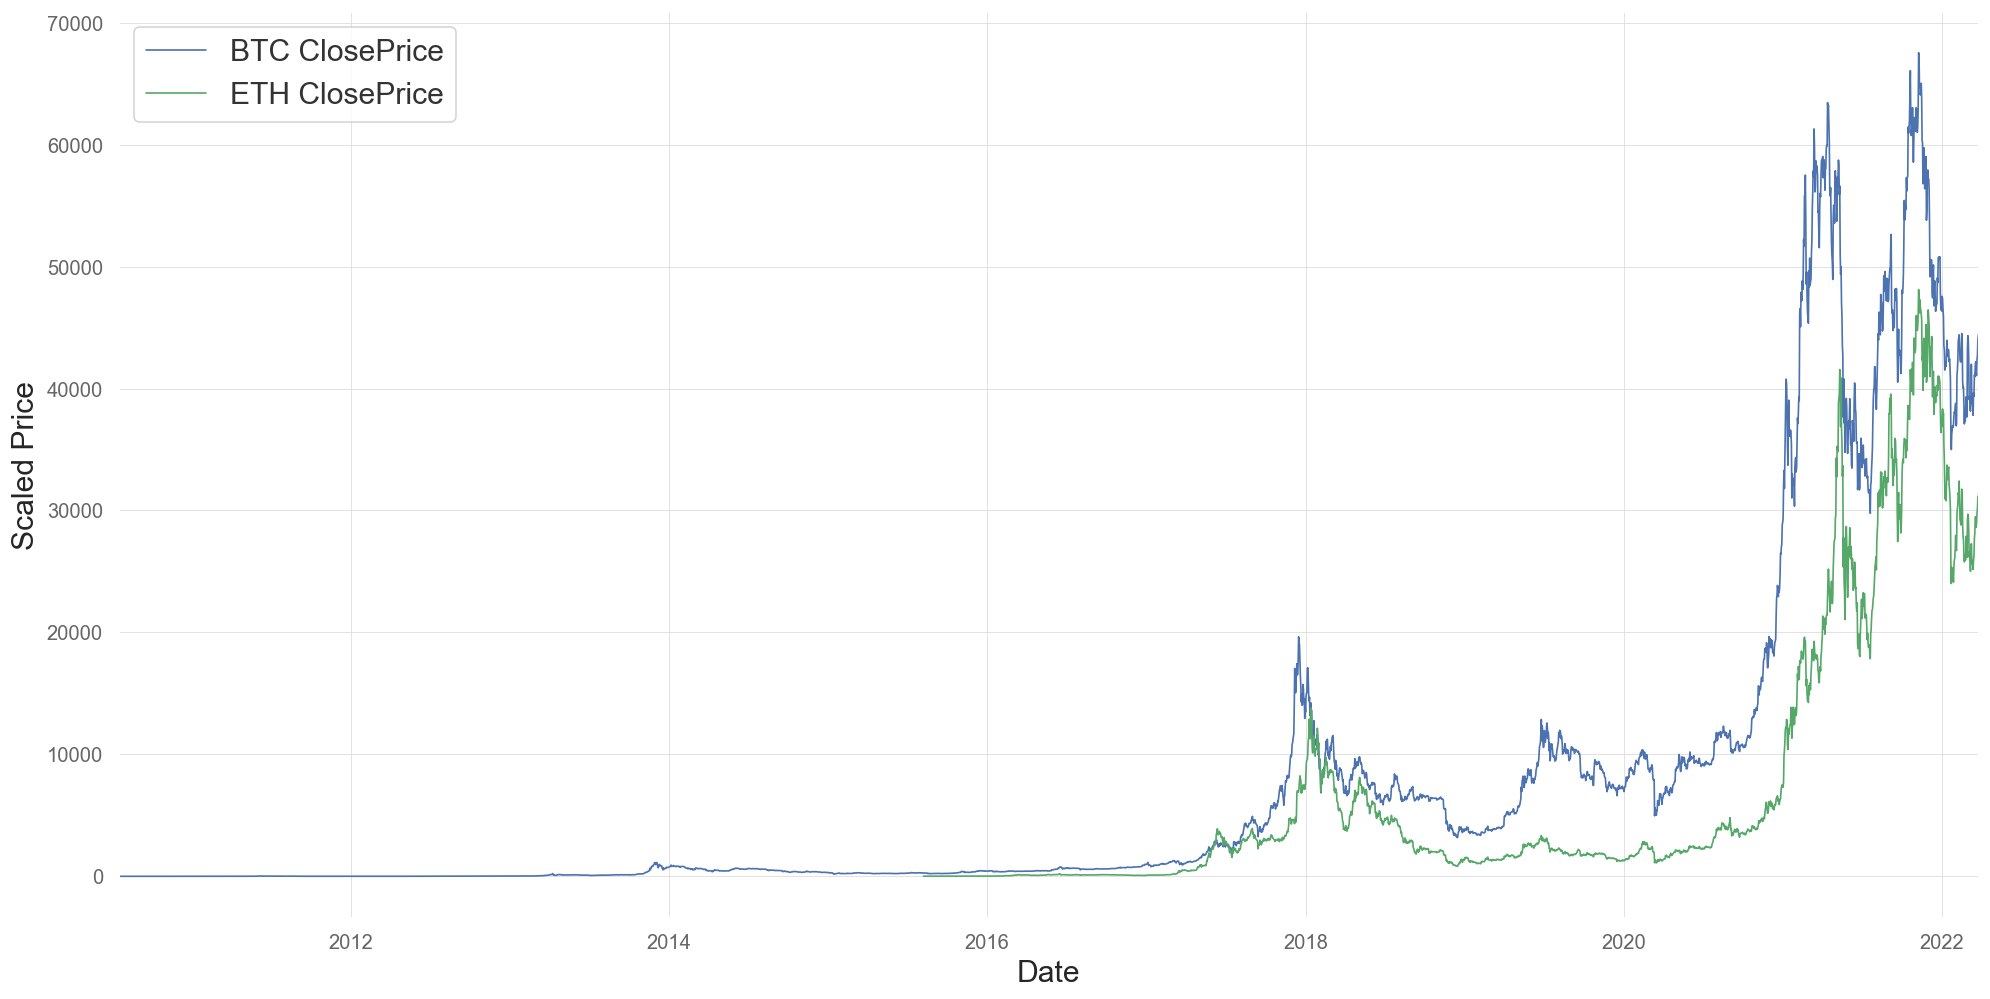

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10), dpi=120)
cycol = cycle('bgrcmky')

price_data = pd.DataFrame()
for symbol in CRYPTO_SYMBOLS:
    multiplier = 1.0
    if symbol == 'ETH':
        multiplier = 10.0
    if symbol == 'XLM':
        multiplier = 100000.0
    label = symbol + ' ClosePrice'
    price_data = price_data.assign(label=pd.Series(assets_data[symbol]['Close'] * multiplier, index=assets_data[symbol].index))
    ax = price_data['label'].plot(color=next(cycol), lw=1., label=label)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Scaled Price', fontsize=18)
plt.legend(prop={'size': 18})
plt.show()

Just for comparison, let's observe the traded volumes.

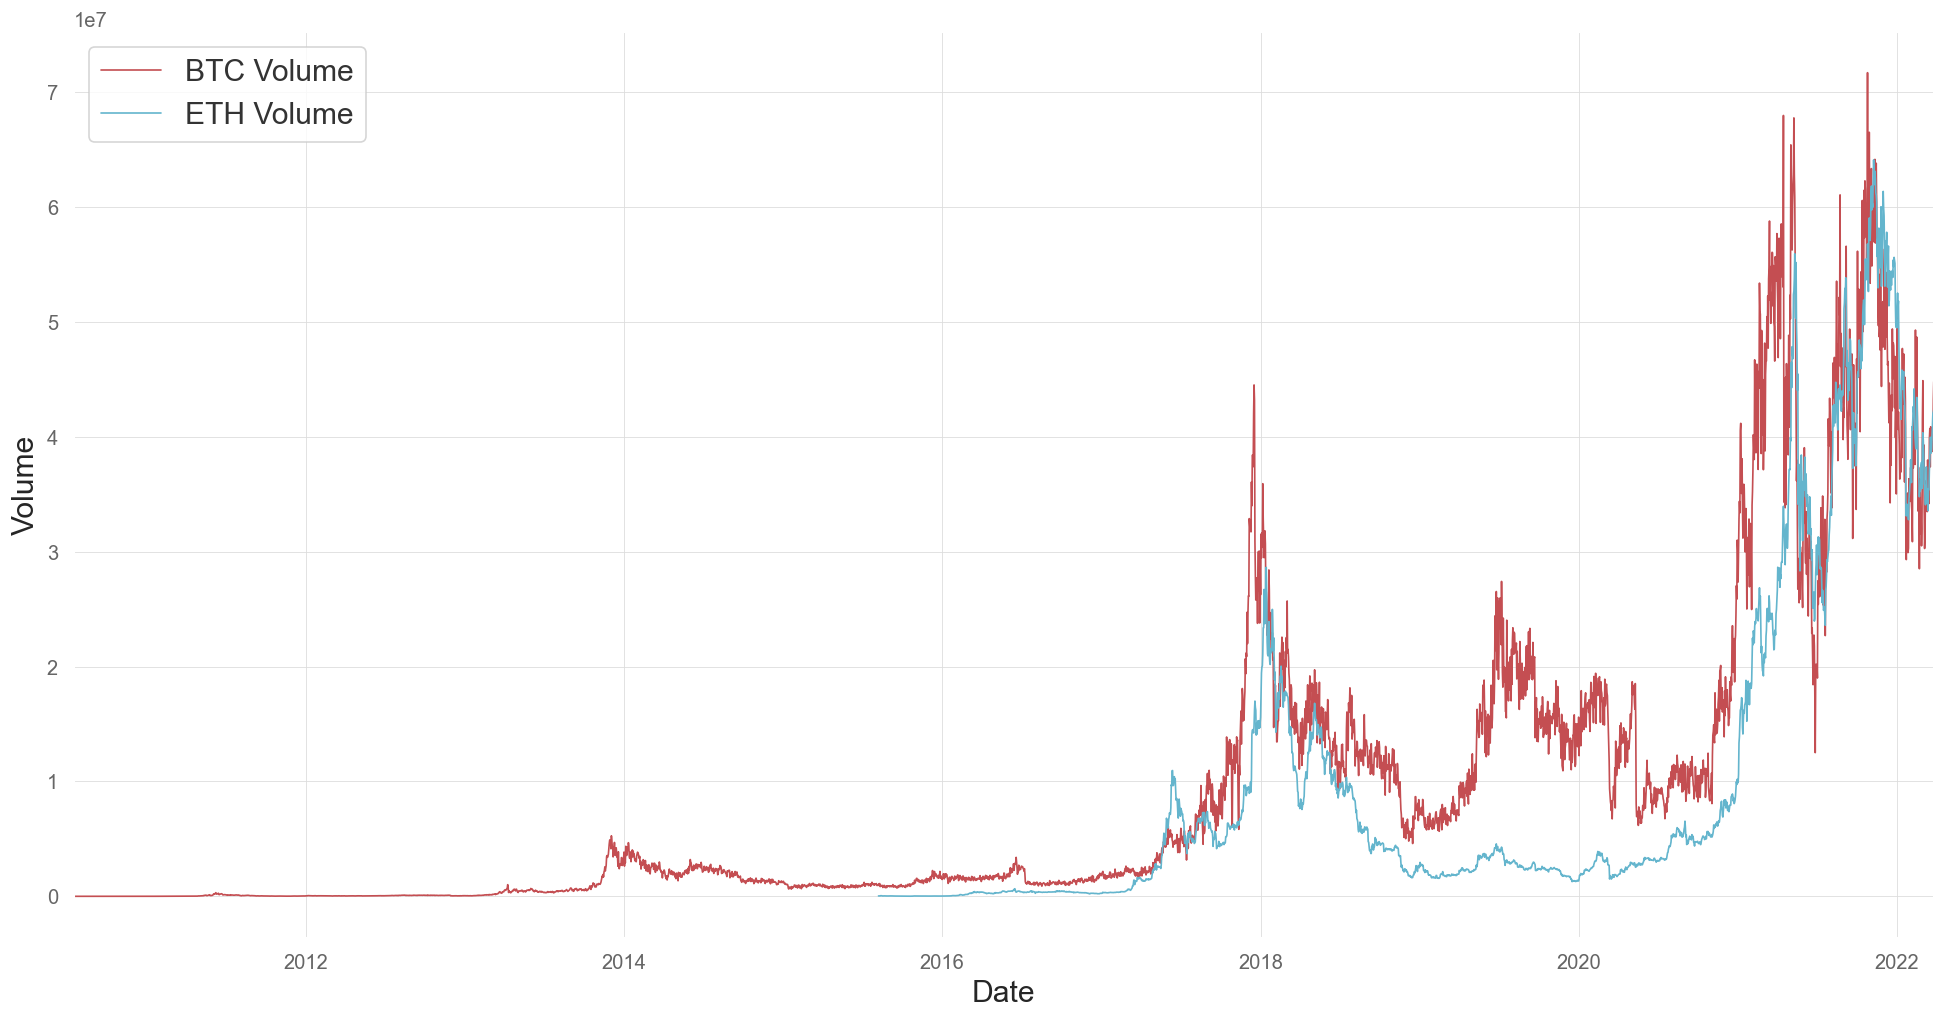

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10), dpi=120)

price_data = pd.DataFrame()
for symbol in CRYPTO_SYMBOLS:
  label = symbol + ' Volume'
  price_data = price_data.assign(label=pd.Series(assets_data[symbol]['Volume'], index=assets_data[symbol].index))
  ax = price_data['label'].plot(color=next(cycol), lw=1., label=label)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volume', fontsize=18)
plt.legend(prop={'size': 18})
plt.show()


### 3.2. ETFs Datasets

Now, the datasets of the remaining assets are loaded (source: Yahoo Finance).

In [17]:
ETF_SYMBOLS = ["MSTR", "BITO", "BITW", "GBTC", "MARA", "RIOT"]

In [18]:
etf_data = {} # A dictionary where we will add the assets.
etf_data[TRADING_INSTRUMENT] = assets_data[TRADING_INSTRUMENT].copy()

for asset in ETF_SYMBOLS:
    etf_data[asset] = pd.read_csv(f"data/{asset}.csv", parse_dates=["Date"], date_parser=string_to_date, index_col="Date")

/var/folders/m4/0s2308nx7fq7k_9gy4v66fqc0000gn/T/ipykernel_6131/1039867226.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  string_to_date = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
/var/folders/m4/0s2308nx7fq7k_9gy4v66fqc0000gn/T/ipykernel_6131/1039867226.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  string_to_date = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
/var/folders/m4/0s2308nx7fq7k_9gy4v66fqc0000gn/T/ipykernel_6131/1039867226.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  string_to_date = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
/var/folders/m4/0s2308nx7fq7k_9gy4v66fqc0000gn/T/ipykernel_6131/1039867226.py:3: FutureWarning: The pandas.datetime class is de

Remove some duplicates that are present in the series.

In [19]:
for symbol in ETF_SYMBOLS:
    if not etf_data[symbol].index.is_unique:
        etf_data[symbol] = etf_data[symbol][~etf_data[symbol].index.duplicated(keep='first')]

There is a lot of information. Let's analyze the closing price and the linear correlation between these assets and the BTC series.

In [20]:
etf_prices = pd.DataFrame()
etf_prices["BTC / USD Denominated Closing Price"] = etf_data["BTC"]["Close"]

for asset in ETF_SYMBOLS:
    etf_prices[f"{asset} / USD Denominated Closing Price"] = etf_data[asset]["Close"]

etf_prices.corr()["BTC / USD Denominated Closing Price"]

BTC / USD Denominated Closing Price     1.000000
MSTR / USD Denominated Closing Price    0.920034
BITO / USD Denominated Closing Price    0.997786
BITW / USD Denominated Closing Price    0.290060
GBTC / USD Denominated Closing Price    0.973749
MARA / USD Denominated Closing Price   -0.187992
RIOT / USD Denominated Closing Price    0.886544
Name: BTC / USD Denominated Closing Price, dtype: float64

Let's do an initial filtering with data from 2017 onwards and then compare the correlation again.

In [21]:
FILTER_START_DATE = '2017-01-01'

In [22]:
etf_prices.loc[etf_prices.index >= FILTER_START_DATE].corr()["BTC / USD Denominated Closing Price"]

BTC / USD Denominated Closing Price     1.000000
MSTR / USD Denominated Closing Price    0.937572
BITO / USD Denominated Closing Price    0.997786
BITW / USD Denominated Closing Price    0.290060
GBTC / USD Denominated Closing Price    0.972183
MARA / USD Denominated Closing Price    0.863649
RIOT / USD Denominated Closing Price    0.884730
Name: BTC / USD Denominated Closing Price, dtype: float64

It is observed that BITO and GBTC have a high correlation with BTC. In this case, we select only GBTC since we have more data available.

In [23]:
ETF_SYMBOLS = ['GBTC']

for asset in ETF_SYMBOLS:
    assets_data[asset] = etf_data[asset].copy()

del(etf_data)

In [24]:
SYMBOLS = list(assets_data.keys()) # CRYPTO_SYMBOLS + ETF_SYMBOLS

Plot the closing prices with scaled axes for some assets to improve visualization.

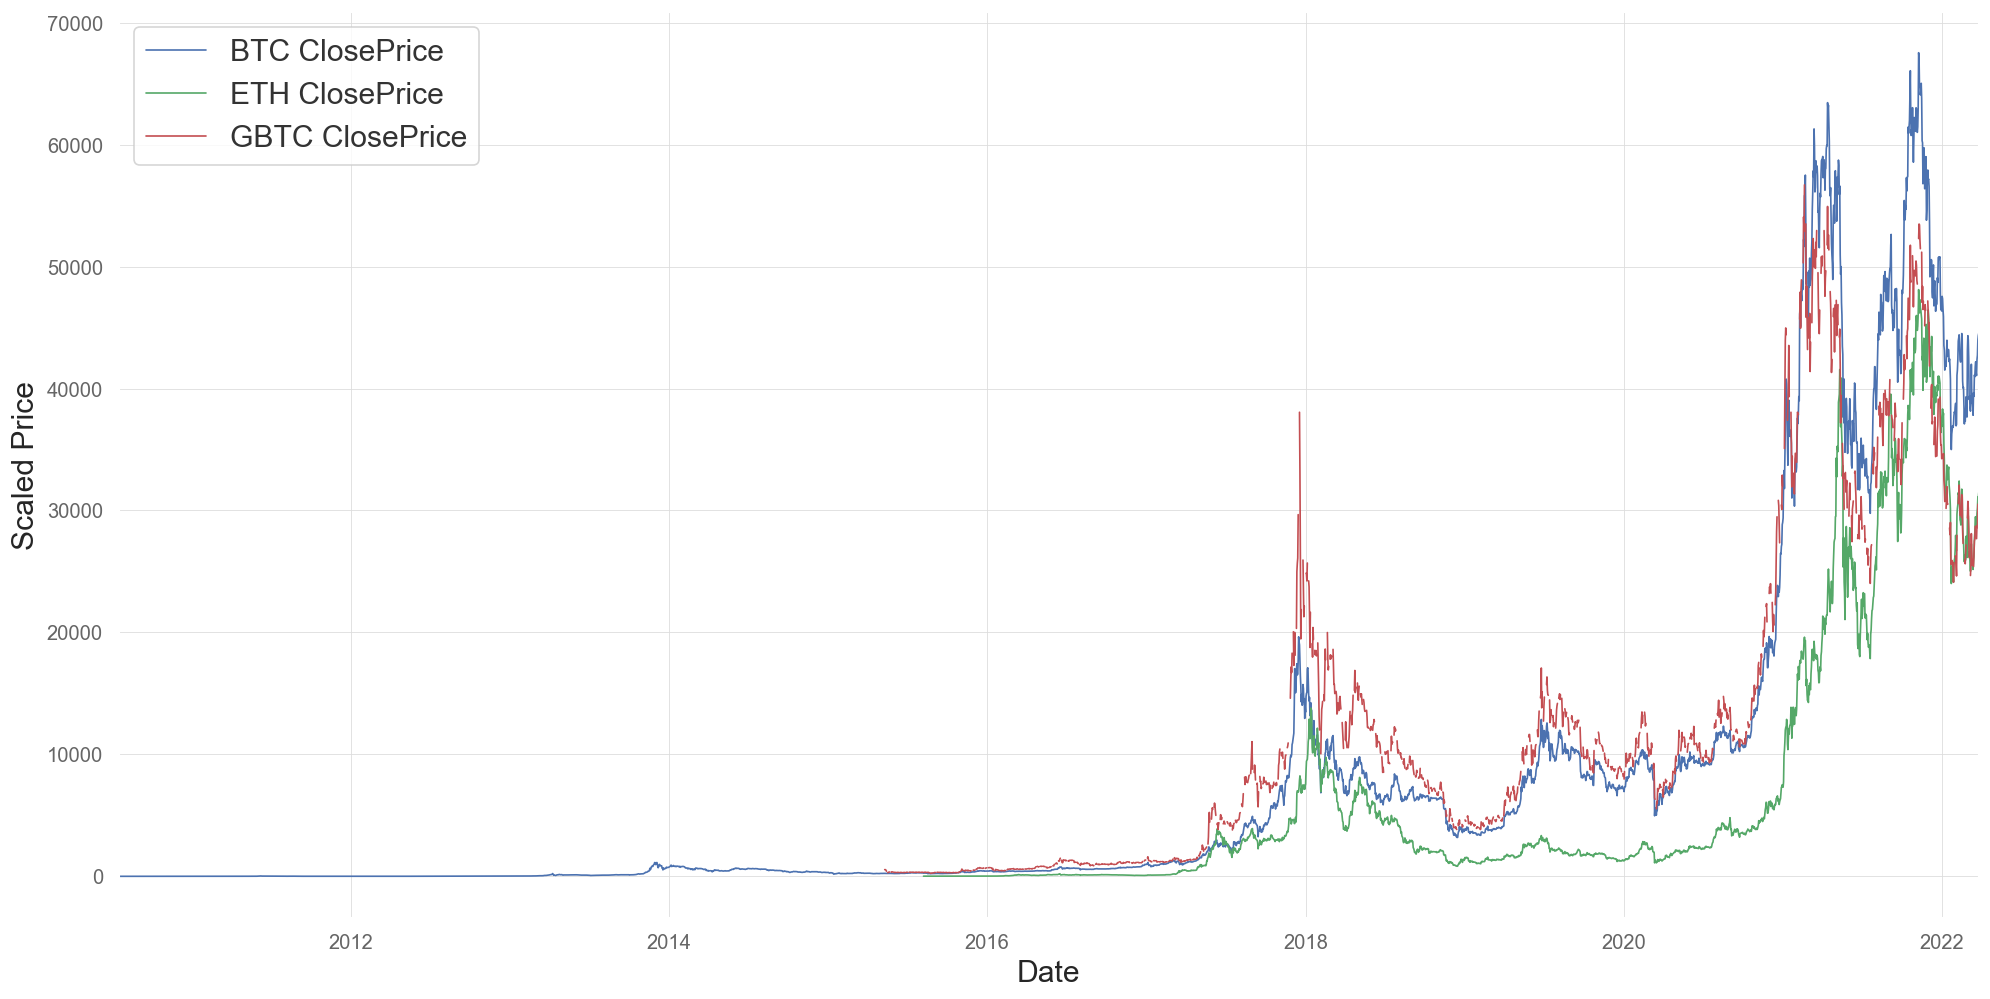

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10), dpi=120)
cycol = cycle('bgrcmky')

price_data = pd.DataFrame()
for symbol in SYMBOLS:

  multiplier = 1.0
  if symbol == 'ETH':
    multiplier = 10.0
  if symbol == 'GBTC':
    multiplier = 1000.0

  label = symbol + ' ClosePrice'
  price_data = price_data.assign(label=pd.Series(assets_data[symbol]['Close'] * multiplier, index=assets_data[symbol].index))
  ax = price_data['label'].plot(color=next(cycol), lw=1., label=label)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Scaled Price', fontsize=18)
plt.legend(prop={'size': 18})
plt.show()

Next, a filtering is performed by selecting records starting from 2017, and matching the indices of each series.

In [26]:
START_DATE = "2017-01-01"
END_DATE = "2022-01-01"

for symbol in SYMBOLS:
    assets_data[symbol] = assets_data[symbol].loc[(assets_data[symbol].index >= START_DATE) & (assets_data[symbol].index <= END_DATE)]
    # print(f"Symbol is: {symbol}")
    # print(assets_data[symbol]['Close'].tail(2))

for symbol in SYMBOLS:
    assets_data[symbol] = assets_data[symbol].loc[assets_data['GBTC'].index] # Join by GBTC index

In [27]:
assets_data[TRADING_INSTRUMENT].shape

(1259, 2)

Let's plot the selected series again.

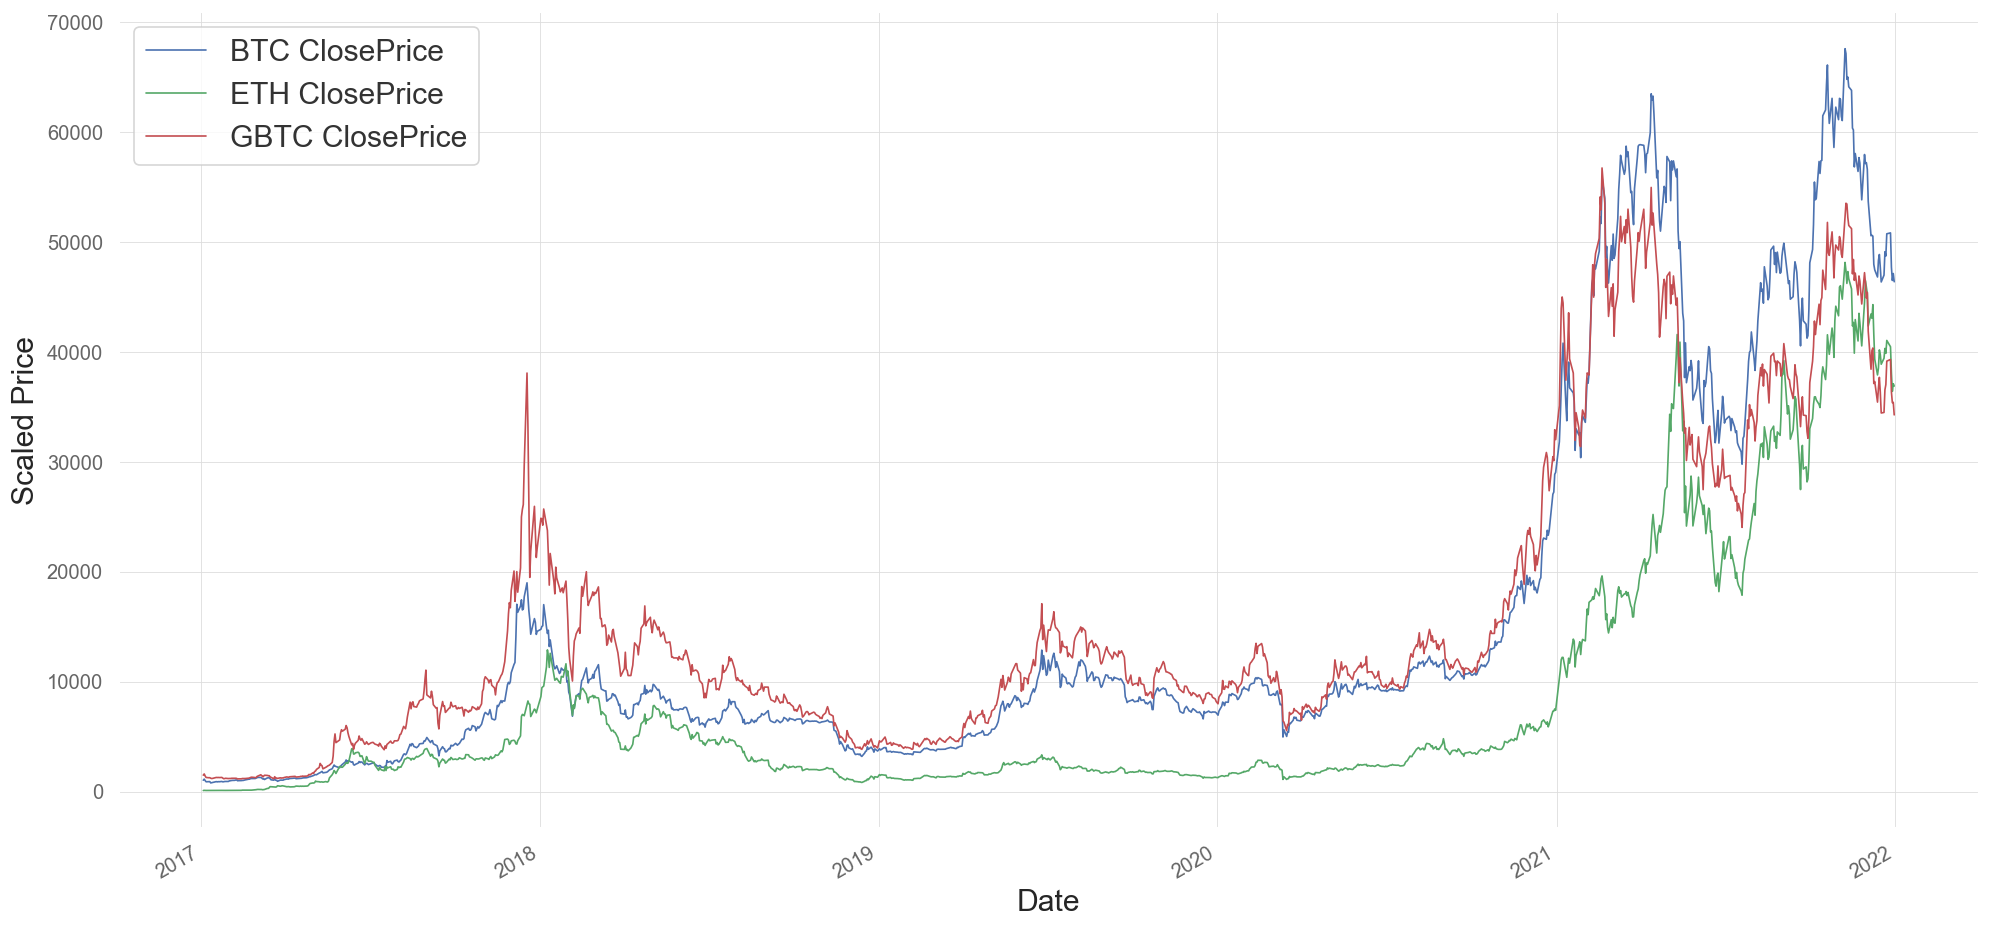

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10), dpi=120)
cycol = cycle('bgrcmky')

price_data = pd.DataFrame()
for symbol in SYMBOLS:

  multiplier = 1.0
  if symbol == 'ETH':
    multiplier = 10.0
  if symbol == 'GBTC':
    multiplier = 1000.0

  label = symbol + ' ClosePrice'
  price_data = price_data.assign(label=pd.Series(assets_data[symbol]['Close'] * multiplier, index=assets_data[symbol].index))
  ax = price_data['label'].plot(color=next(cycol), lw=1., label=label)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Scaled Price', fontsize=18)
plt.legend(prop={'size': 18})
plt.show()

### 3.3. Volatilities

In [ ]:
# Compute the daily volatility, smoothed with a 50-day weighted moving average (arbitrary, could also be learned).
daily_vol = {}
for asset in SYMBOLS:
    daily_vol[asset] = labeling.getDailyVol(close=assets_data[asset]['Close'], span0=50)

In [30]:
# Min, avg, and max volatility.
for asset in daily_vol:
    print(f"Volatilidades de {asset}")
    print(f"Volatilidad mínima: {daily_vol[asset].min()}")
    print(f"Volatilidad media: {daily_vol[asset].mean()}")
    print(f"Volatilidad máxima: {daily_vol[asset].max()}")

Volatilidades de BTC
Volatilidad mínima: 0.02909378685951141
Volatilidad media: 0.06398460333185714
Volatilidad máxima: 0.12886473091497652
Volatilidades de ETH
Volatilidad mínima: 0.03218820077873585
Volatilidad media: 0.08825745258547373
Volatilidad máxima: 0.18349341023833035
Volatilidades de GBTC
Volatilidad mínima: 0.04032125456202761
Volatilidad media: 0.07895245730941623
Volatilidad máxima: 0.1917519437431745


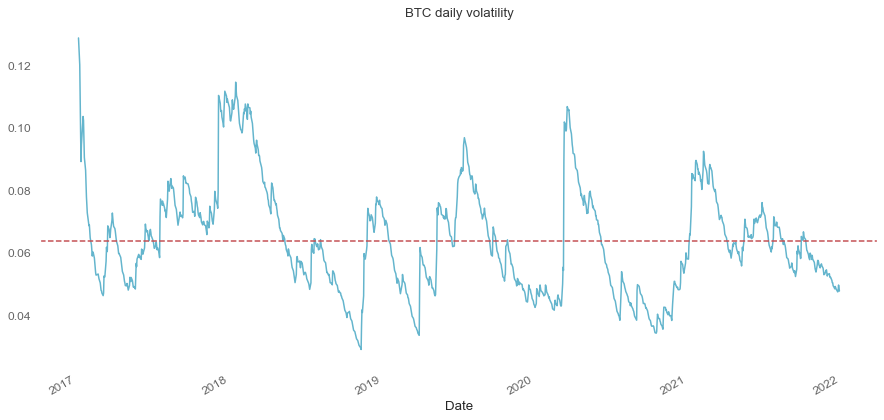

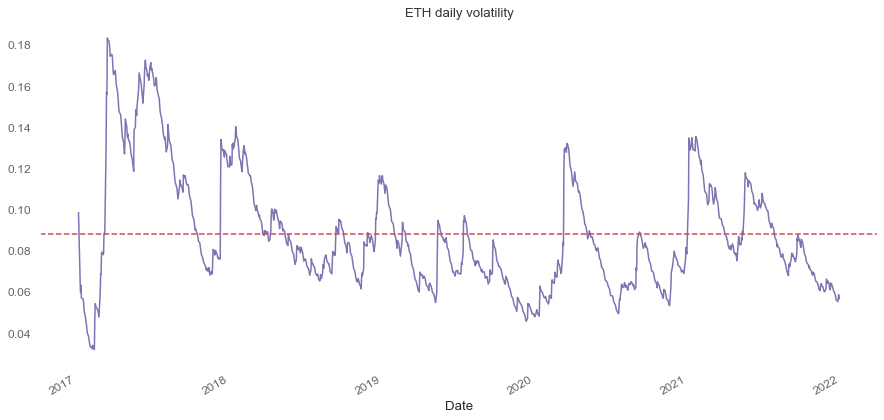

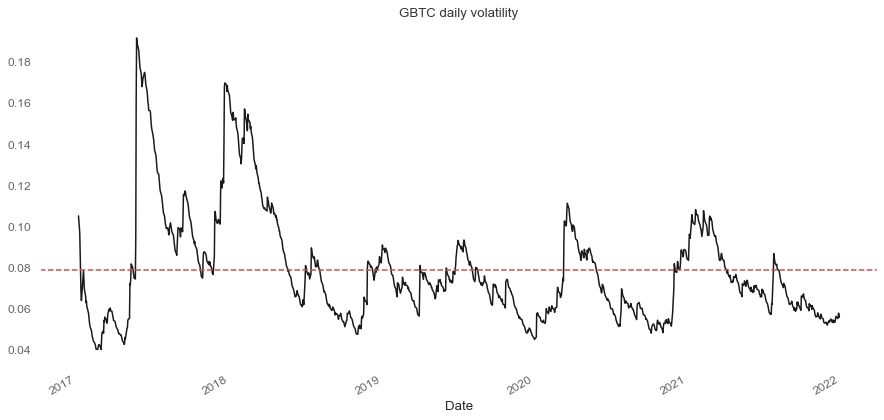

In [31]:
# Plot the volatility over the history of BTC. The red line shows the average value.
for asset in SYMBOLS:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))    
    daily_vol[asset].plot(kind='line',y='dailyVol', color=next(cycol), ax=ax)
    ax.axhline(daily_vol[asset].mean(),ls='--',color='r')
    plt.title(f"{asset} daily volatility")
    plt.grid()
    plt.show()

It should be noted that volatility is not constant, especially in the early years of the series (approximately 0.08 +- 0.18), as some methodologies do not work well with fluctuating volatility.

## 5. Labeling

To construct the betting side, the *pairs trading* strategy is implemented. Much of the code was obtained from Chapter 5 of *Learn Algorithmic Trading*.

### 5.1. Implementation of *pairs trading*

In [32]:
strategy_btc_eth_gbtc = pairs_trading.PairsTradingStrategy(TRADING_INSTRUMENT, SYMBOLS, assets_data)

First, the initial parameters of the signal are defined. In particular, we take SMA_NUM_PERIODS = 5 and PRICE_DEV_NUM_PRICES = 50 due to the high volatility (values to be optimized).

In [33]:
strategy_btc_eth_gbtc.init_parameters(num_days=len(assets_data[TRADING_INSTRUMENT].index), SMA_NUM_PERIODS=5, PRICE_DEV_NUM_PRICES=50)

Next, other parameters related to the strategy are defined. Remember that the strategy aims to be long/short on BTC and short/long on its proxies. Thus, the values of the last constants are related to BTC/USD.

In [34]:
strategy_btc_eth_gbtc.init_thresholds()

The last variables present an opportunity for improvement and optimization. For example, they can be values relative to the last price and not absolute, thus requiring optimization of that percentage. However, for the sake of simplicity and respecting the given strategy, this will not be considered.
Additionally, a portfolio limit can be added, both for being long and short. Moreover, the commissions for each trade can be included. This will be done in another section.

In the following block, the trading is computed. For further detail, comments are added in each section.

In [35]:
strategy_btc_eth_gbtc.run_strategy(column='Close')

Buy  1  @  1000.49812893045 Position:  1
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Buy  1  @  892.463955639977 Position:  2
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
Buy  1  @  788.314655990649 Position:  3
OpenPnL:  -79.96418977206304  ClosedPnL:  0  TotalPnL:  -79.96418977206304
Sell  1  @  807.109833547633 Position:  2
OpenPnL:  -316.33277258912915  ClosedPnL:  0  TotalPnL:  -316.33277258912915
Buy  1  @  902.263869959088 Position:  3
OpenPnL:  -99.14817812195656  ClosedPnL:  0  TotalPnL:  -99.14817812195656
Sell  1  @  916.6674685564 Position:  2
OpenPnL:  -89.16555783167814  ClosedPnL:  0  TotalPnL:  -89.16555783167814
Buy  1  @  1023.3174811806 Position:  3
OpenPnL:  -67.9930031560491  ClosedPnL:  0  TotalPnL:  -67.9930031560491
Sell  1  @  1052.36764535359 Position:  2
OpenPnL:  13.286906113384703  ClosedPnL:  0  TotalPnL:  13.286906113384703
Sell  1  @  982.751939450614 Position:  1
OpenPnL:  143.02611945060187  ClosedPnL:  0  TotalPnL:  143.02611945060187
Sell  1  @  996.650

### 5.2. Analysis of the strategy

Once the strategy is implemented, let's analyze some aspects.

First, let's observe the evolution of the correlation between BTC and its proxies (ETH and GBTC).

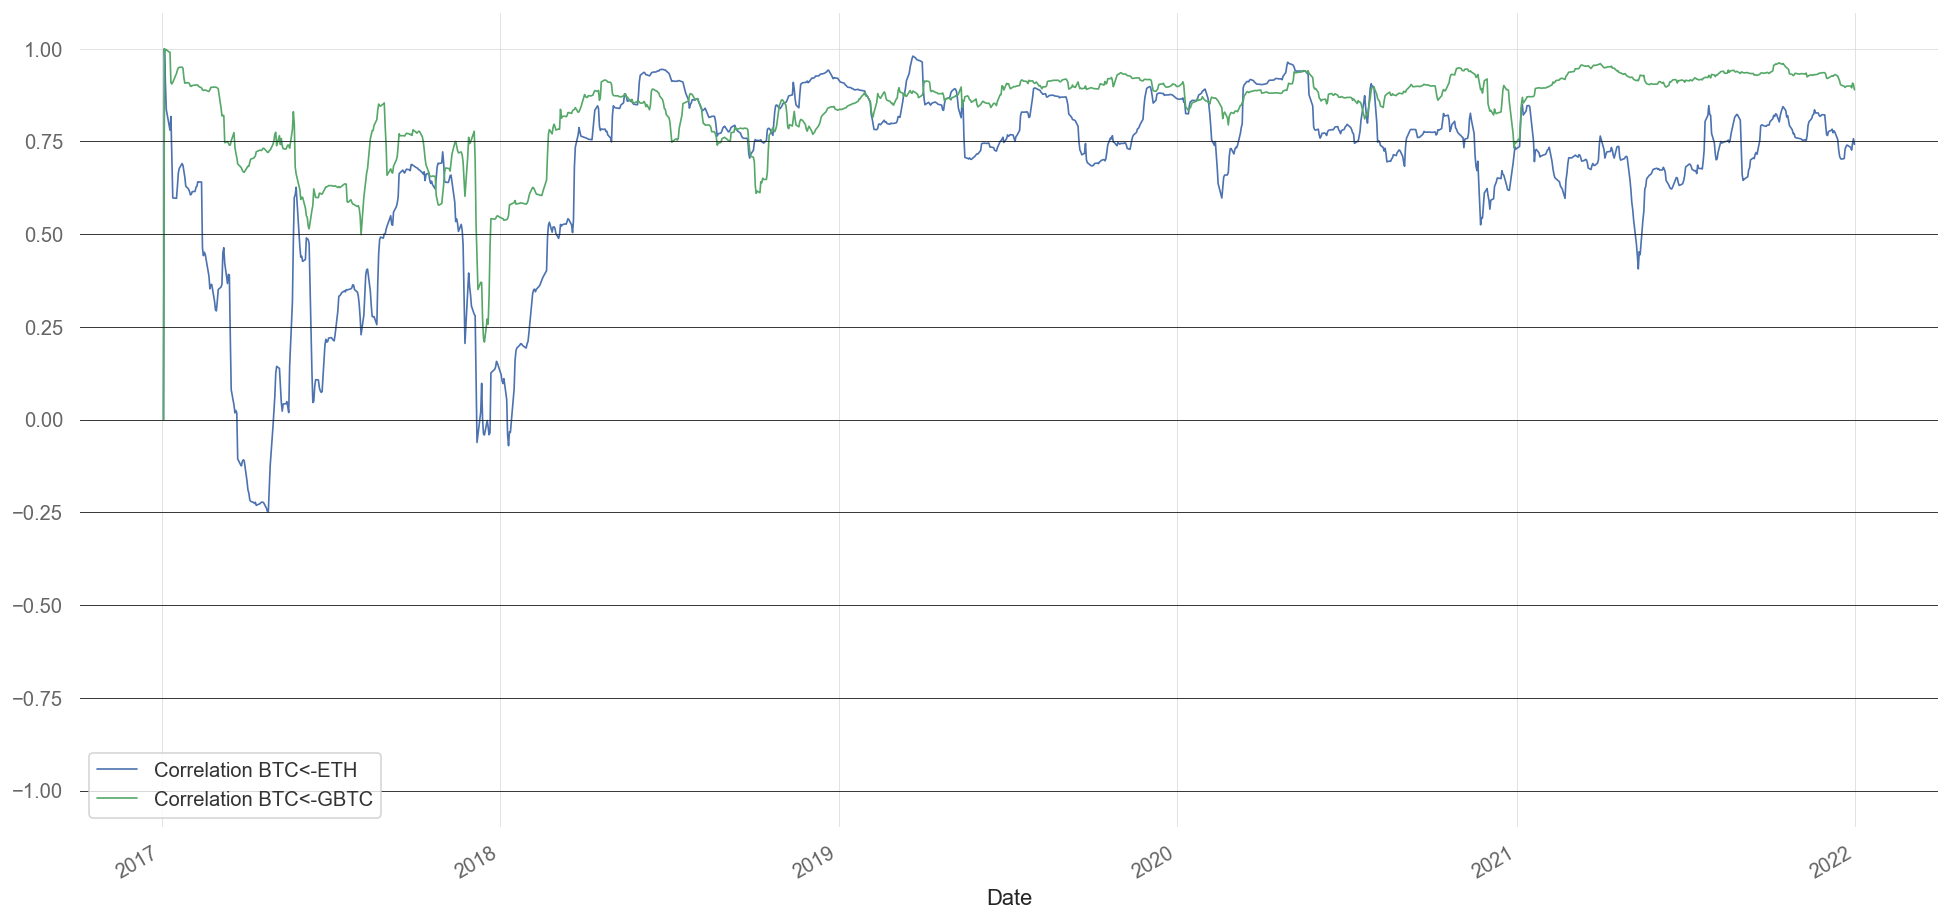

In [36]:
strategy_btc_eth_gbtc.plot_correlations()

It is observed that the correlation is not particularly good at the beginning of the series, mainly for ETH/BTC. This signal can introduce erroneous signals into our strategy, decreasing its performance.

Let's now observe the trading signal for each of the proxies.

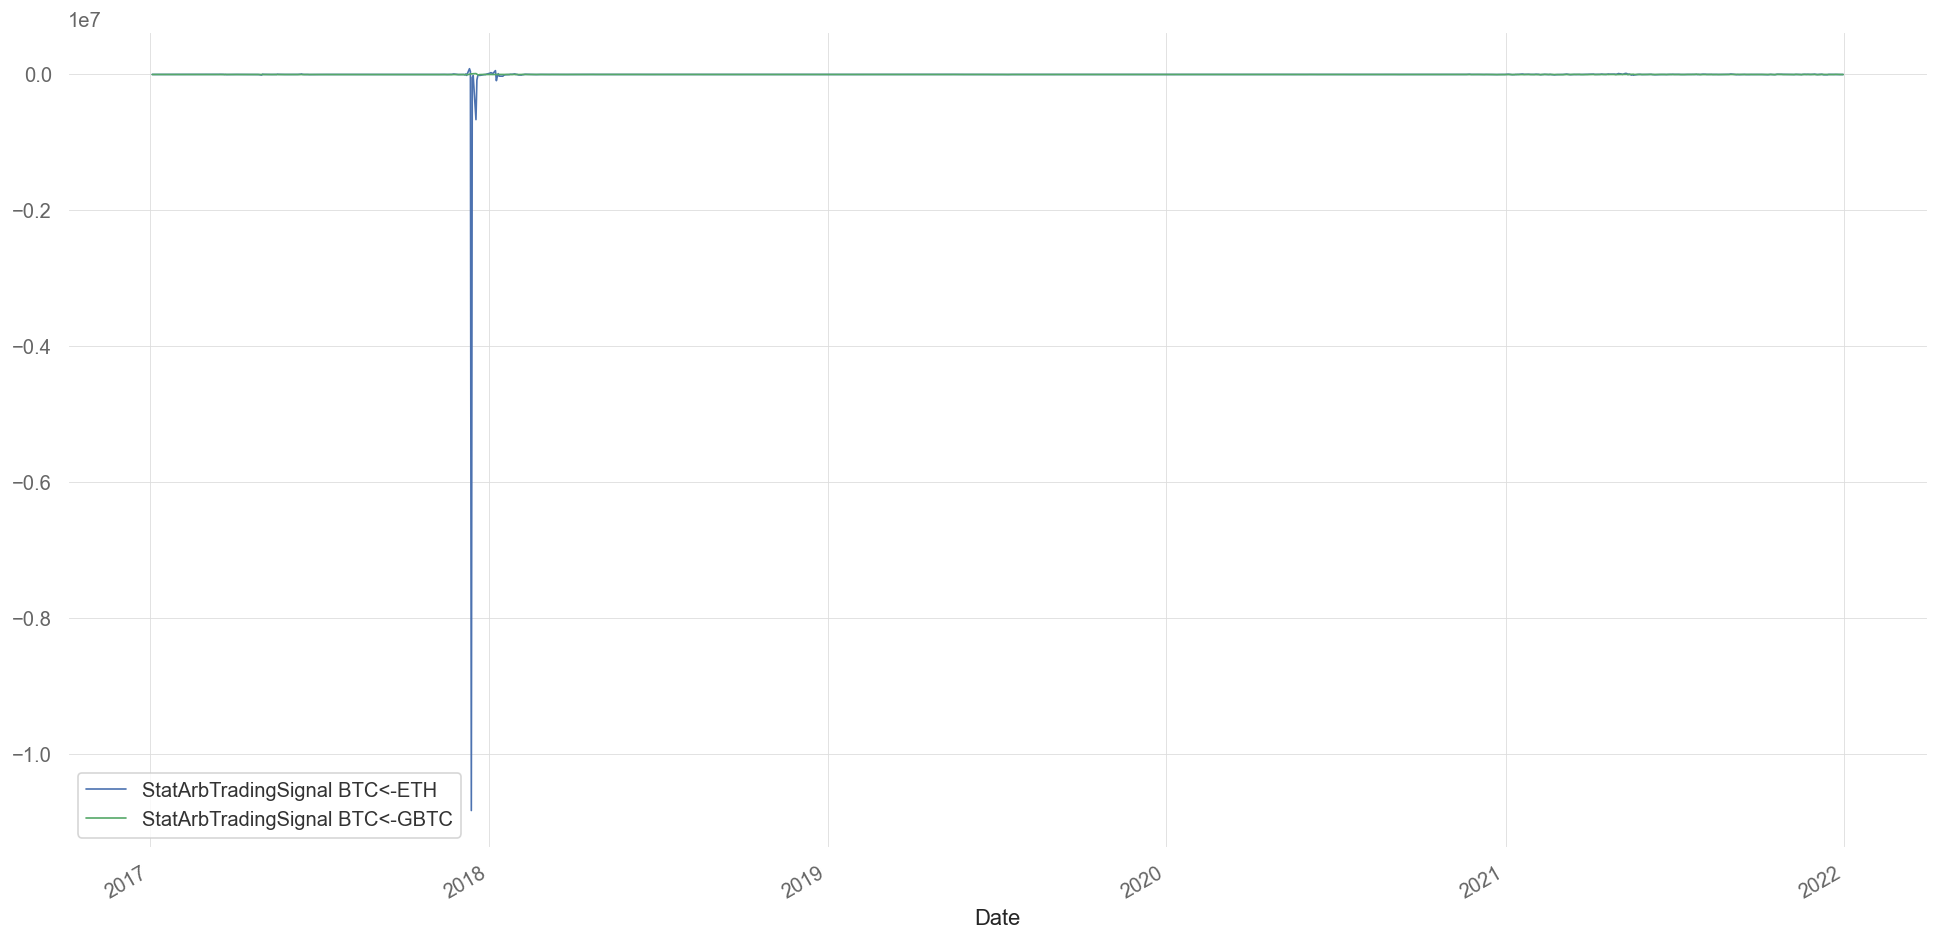

In [37]:
strategy_btc_eth_gbtc.plot_trading_signal()

It is observed that the signal for ETH at one point becomes very high. This indicates a poor prediction, precisely because the BTC-ETH relationship is not very good, and the strategy fails.

Let's then return to applying the strategy only with GBTC as the proxy:

In [38]:
asset_to_remove = SYMBOLS.pop(1)
assets_data.pop(asset_to_remove)

Close        Volume
Date                                 
2017-01-03     9.697472  3.057325e+05
2017-01-04    11.068632  3.552979e+05
2017-01-05    10.224794  3.253226e+05
2017-01-06    10.125832  3.175413e+05
2017-01-09    10.364829  3.290865e+05
...                 ...           ...
2021-12-27  4044.388477  5.509468e+07
2021-12-28  3806.110236  5.146503e+07
2021-12-29  3638.663379  4.956746e+07
2021-12-30  3708.037335  5.020984e+07
2021-12-31  3686.951792  4.948765e+07

[1259 rows x 2 columns]

Firstly, let's reinitialize the parameters.

In [39]:
strategy_btc_gbtc = pairs_trading.PairsTradingStrategy(TRADING_INSTRUMENT, SYMBOLS, assets_data)
strategy_btc_gbtc.init_parameters(num_days=len(assets_data[TRADING_INSTRUMENT].index), SMA_NUM_PERIODS=5, PRICE_DEV_NUM_PRICES=50)
strategy_btc_gbtc.init_thresholds()

Then we run the strategy.

In [40]:
strategy_btc_gbtc.run_strategy()


Sell  1  @  903.508666803039 Position:  -1
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Buy  1  @  788.314655990649 Position:  0
OpenPnL:  -2.990280596143066  ClosedPnL:  0  TotalPnL:  -2.990280596143066
Sell  1  @  906.026828112215 Position:  -1
OpenPnL:  0  ClosedPnL:  115.19401081238993  TotalPnL:  115.19401081238993
Buy  1  @  902.263869959088 Position:  0
OpenPnL:  24.767012741087  ClosedPnL:  115.19401081238993  TotalPnL:  139.96102355347693
Sell  1  @  919.115744126242 Position:  -1
OpenPnL:  0  ClosedPnL:  118.95696896551692  TotalPnL:  118.95696896551692
Buy  1  @  895.690033255406 Position:  0
OpenPnL:  31.372550321450035  ClosedPnL:  118.95696896551692  TotalPnL:  150.32951928696696
Sell  1  @  916.6674685564 Position:  -1
OpenPnL:  0  ClosedPnL:  142.38267983635296  TotalPnL:  142.38267983635296
Sell  1  @  1023.3174811806 Position:  -2
OpenPnL:  -98.63457089421001  ClosedPnL:  142.38267983635296  TotalPnL:  43.74810894214295
Buy  1  @  1012.2134635301 Position:  -1
OpenPnL:  -

First, let's observe the evolution of the correlation between BTC and GBTC.

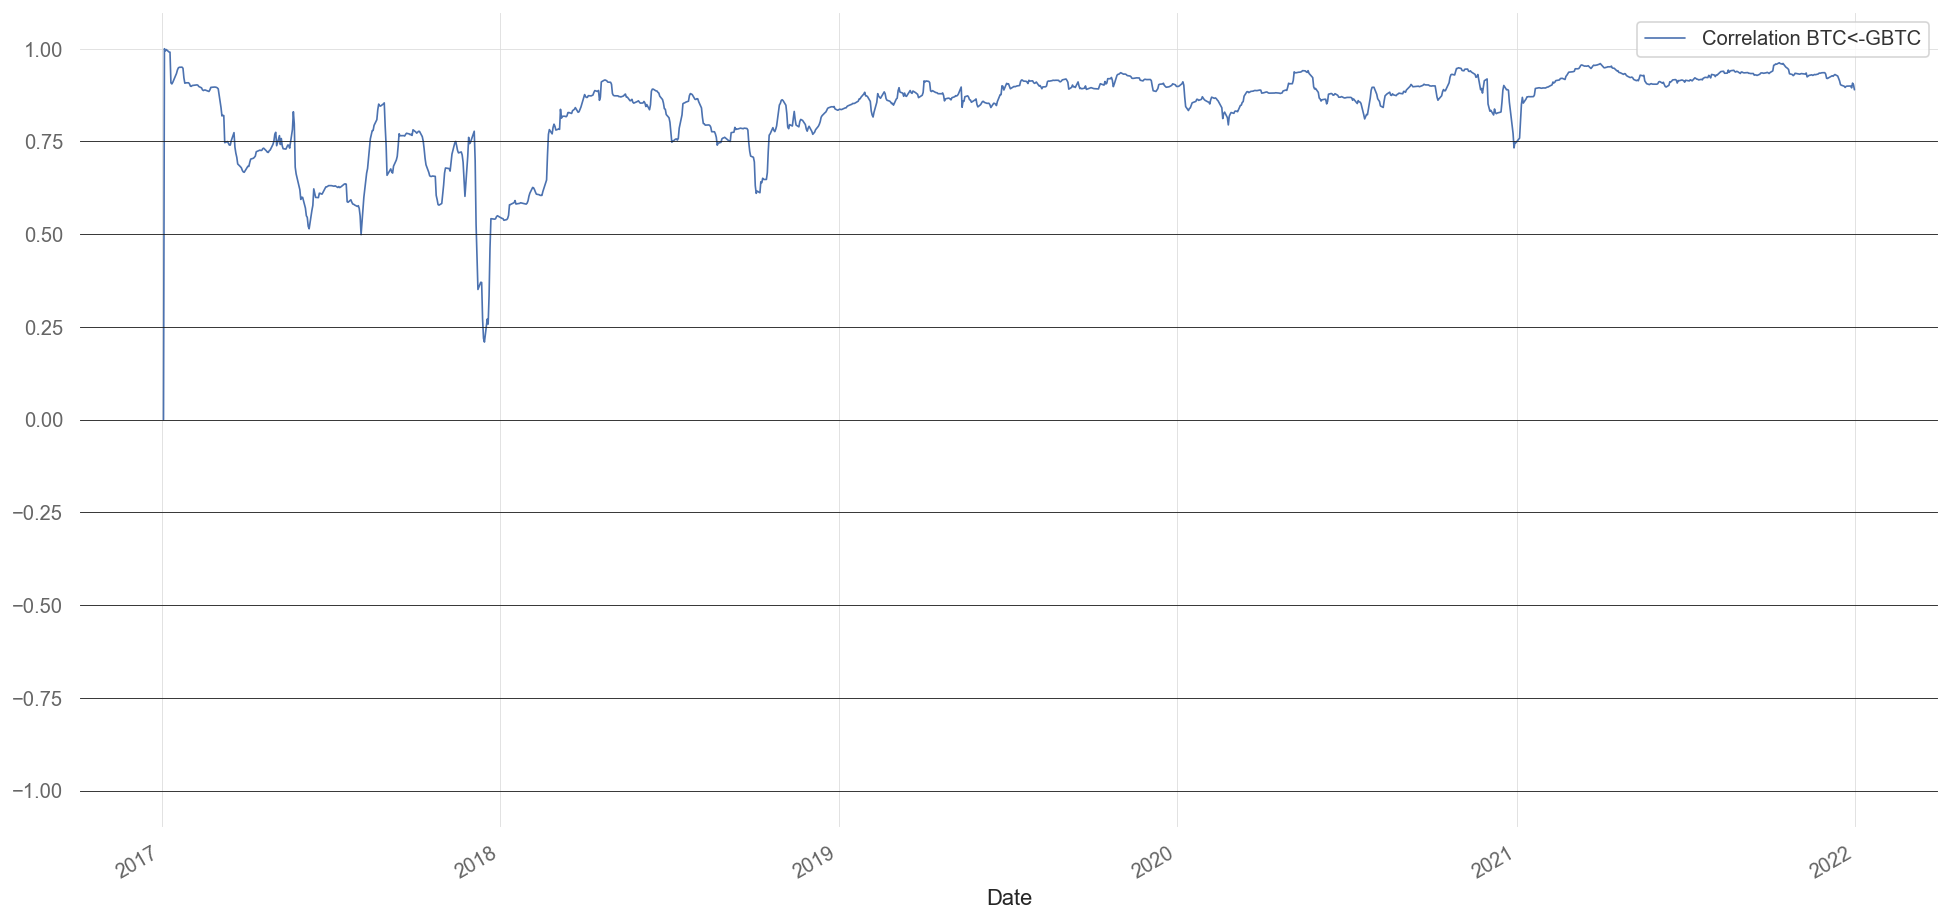

In [41]:
strategy_btc_gbtc.plot_correlations()

Then, the trading signal.

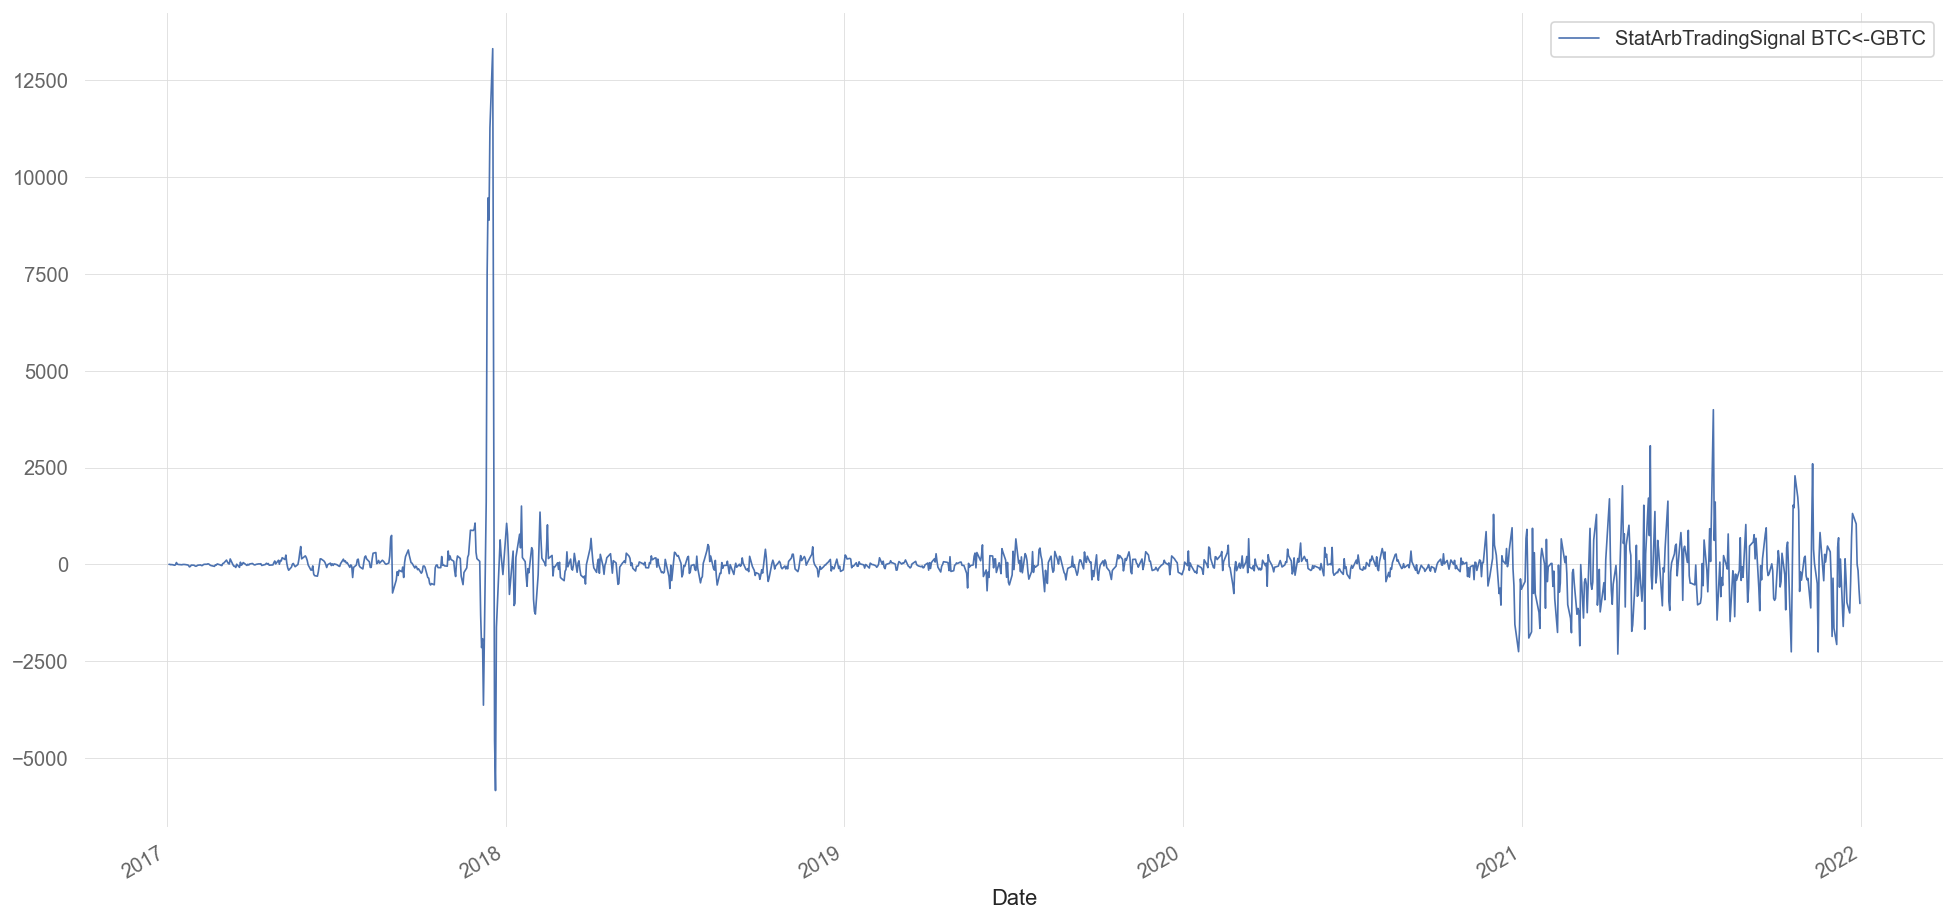

In [42]:
strategy_btc_gbtc.plot_trading_signal()

It is observed that the magnitude of the signal is much lower than that exhibited by ETH previously. However, there is still a peak at the end of 2017, which coincides with the low correlation exhibited by the assets at that time.

Next, let's observe the buy and sell signals throughout the BTC price series.

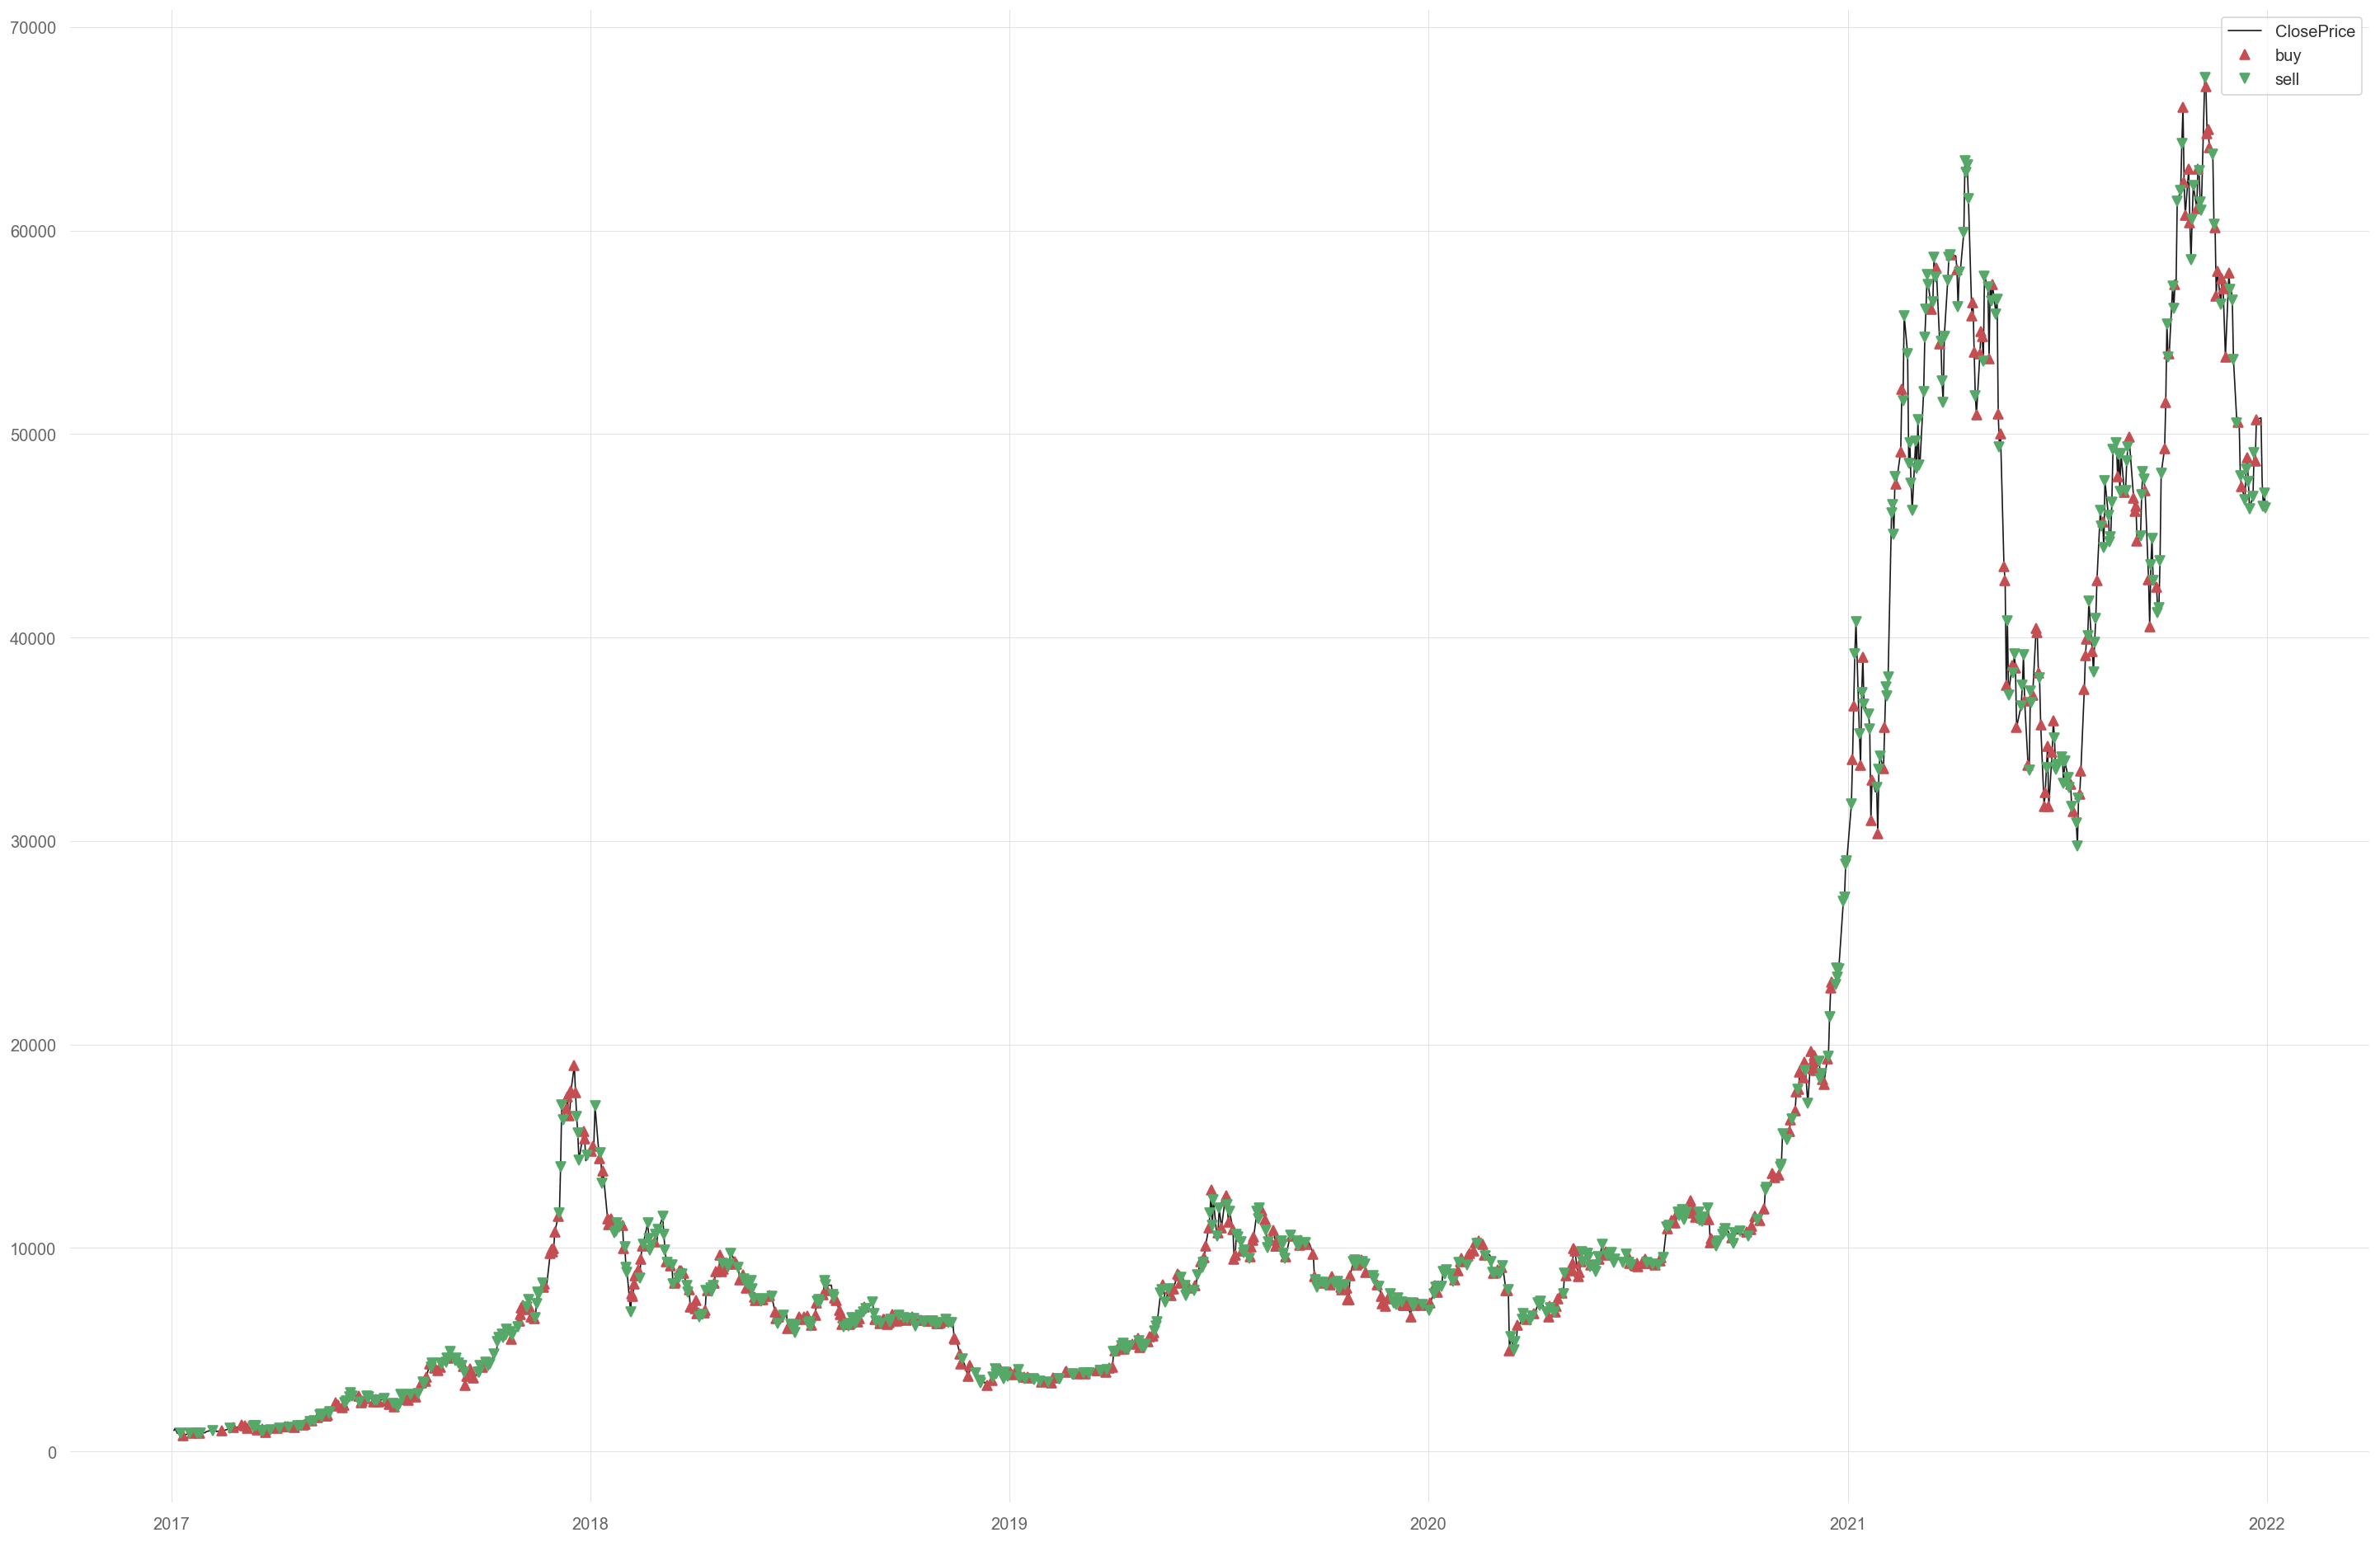

In [43]:
strategy_btc_gbtc.plot_prices_with_signals()

In comparison to what was observed in class, there are many buy/sell signals. This may be due to poorly optimized parameters.

Next, the final trading signal is plotted.

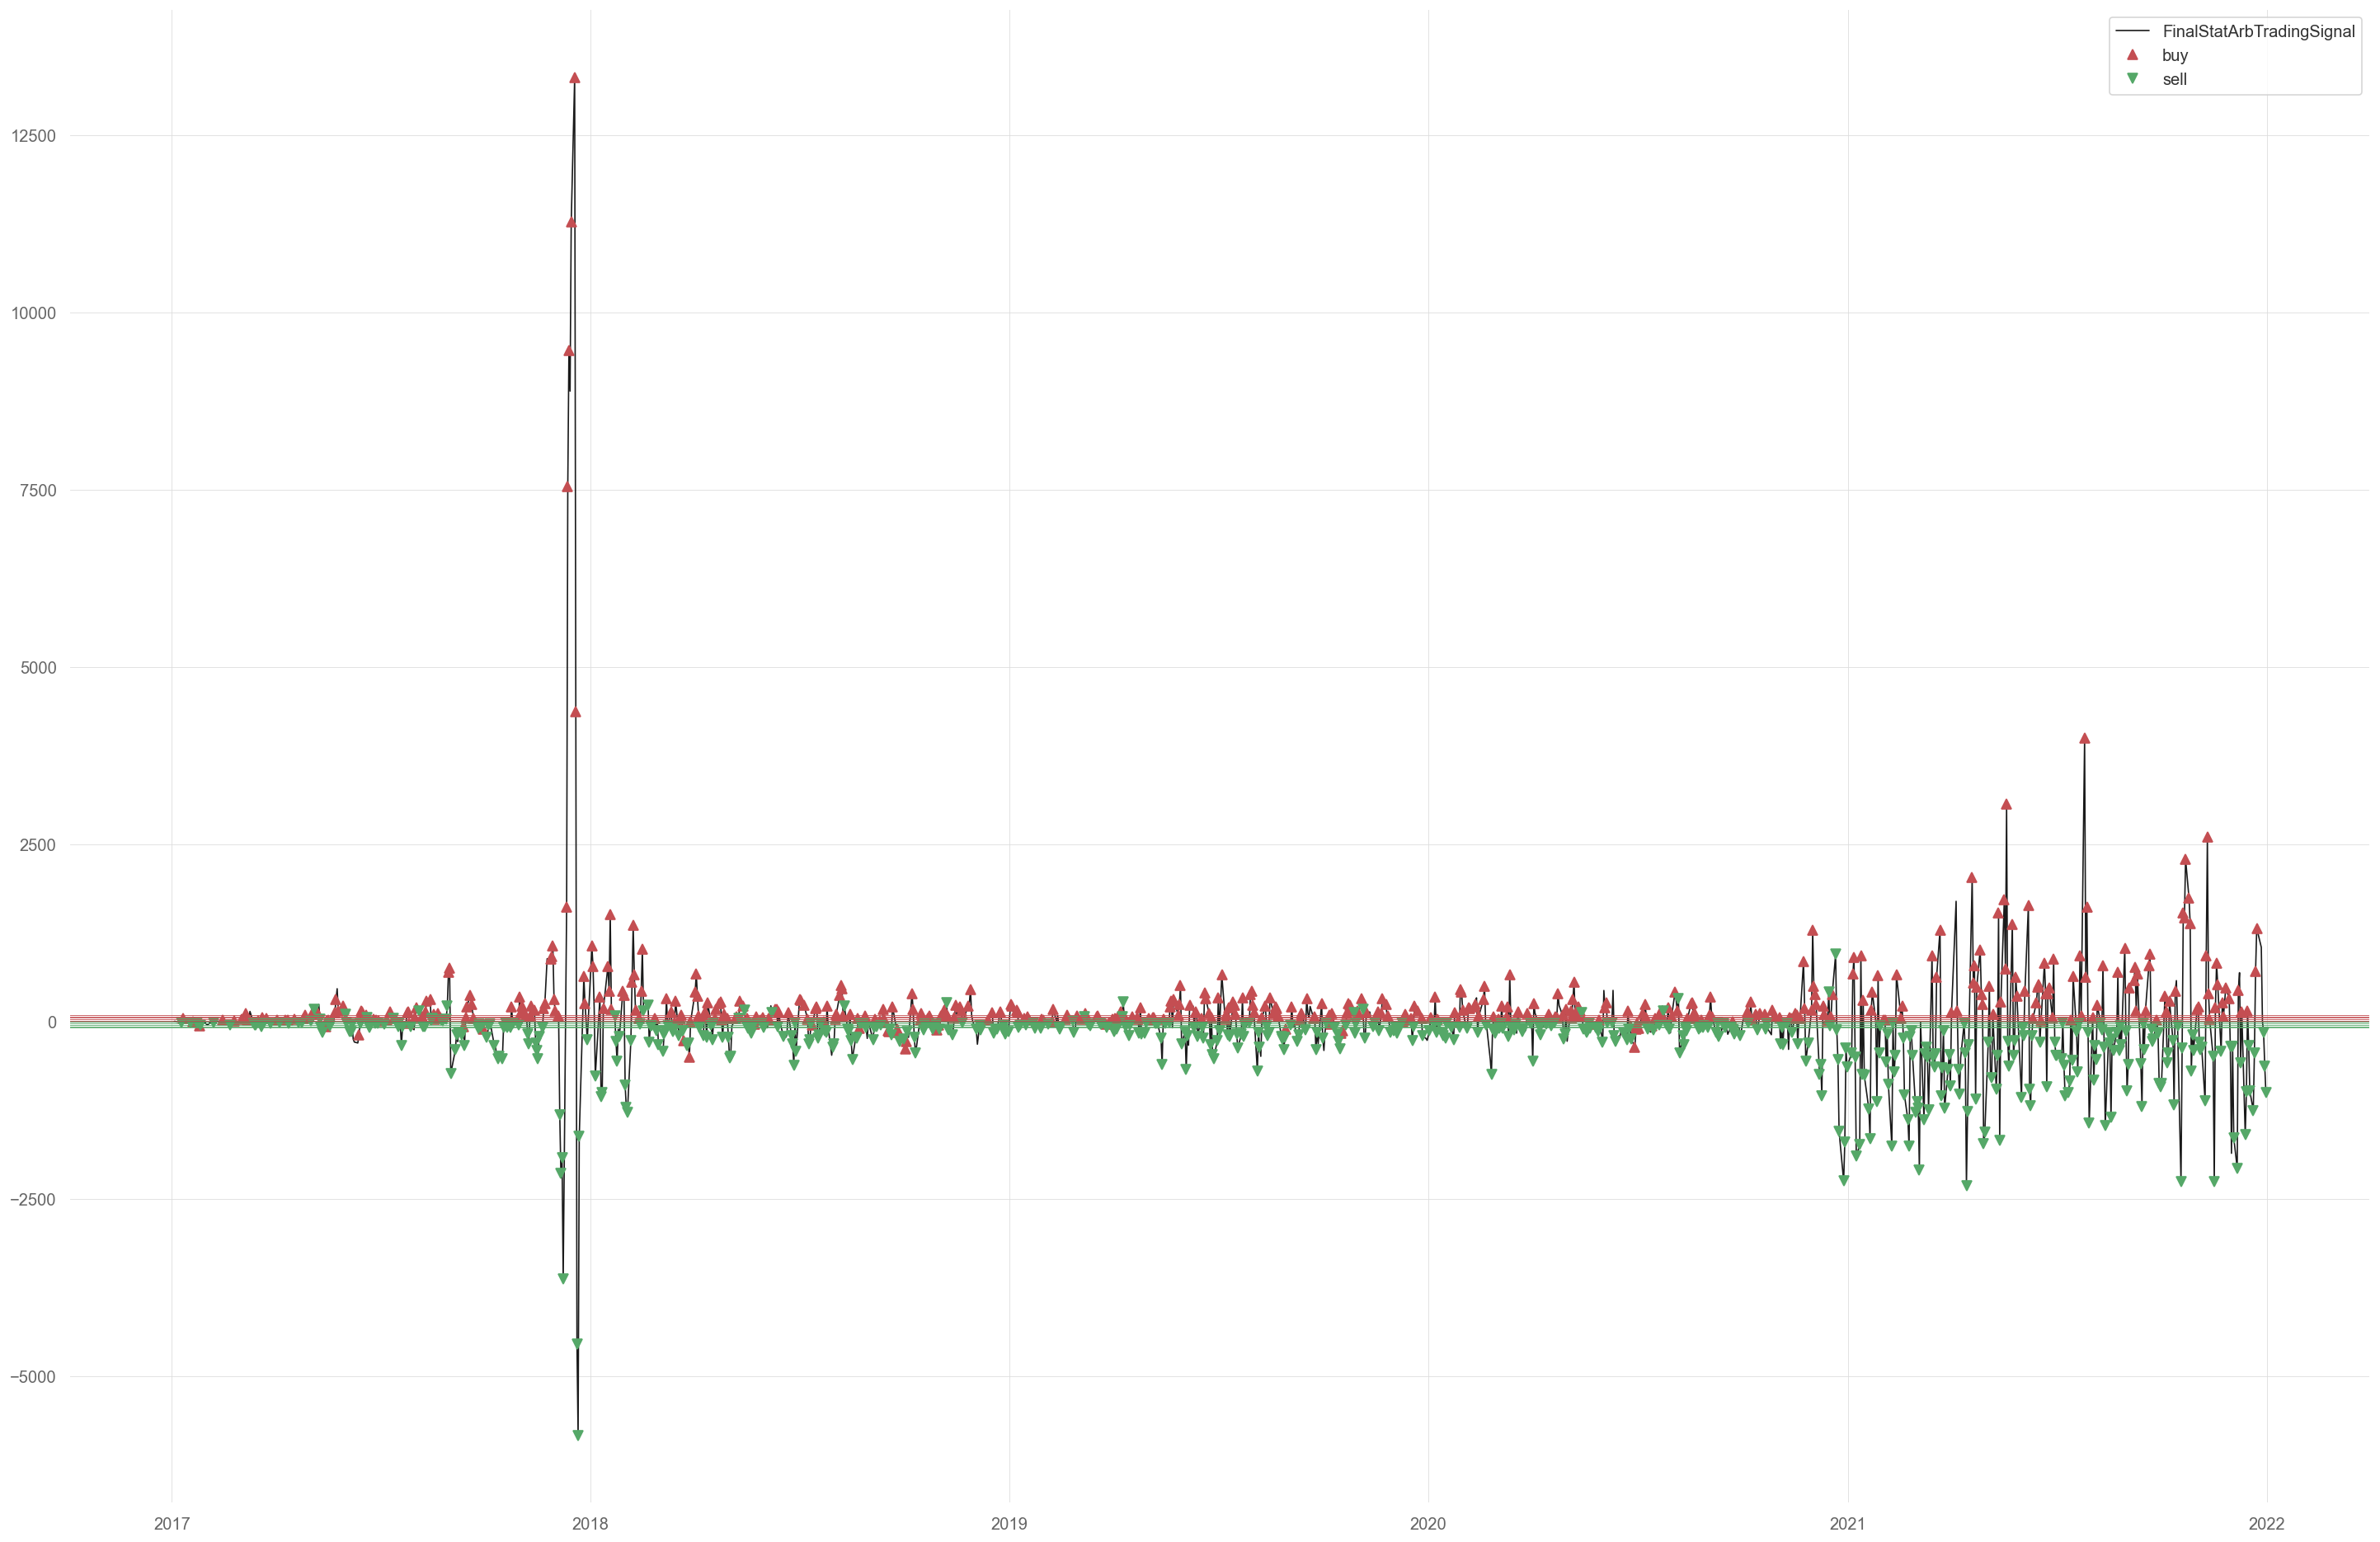

In [44]:
strategy_btc_gbtc.plot_final_trading_signal()

In accordance with the applied strategy, buy trades are observed when the signal is positive and sell trades when it is negative. However, in some rare cases, the opposite is observed, which is attributed to profit-taking orders being closed.

In the following graphs, the positions and P&L of the strategy are observed.

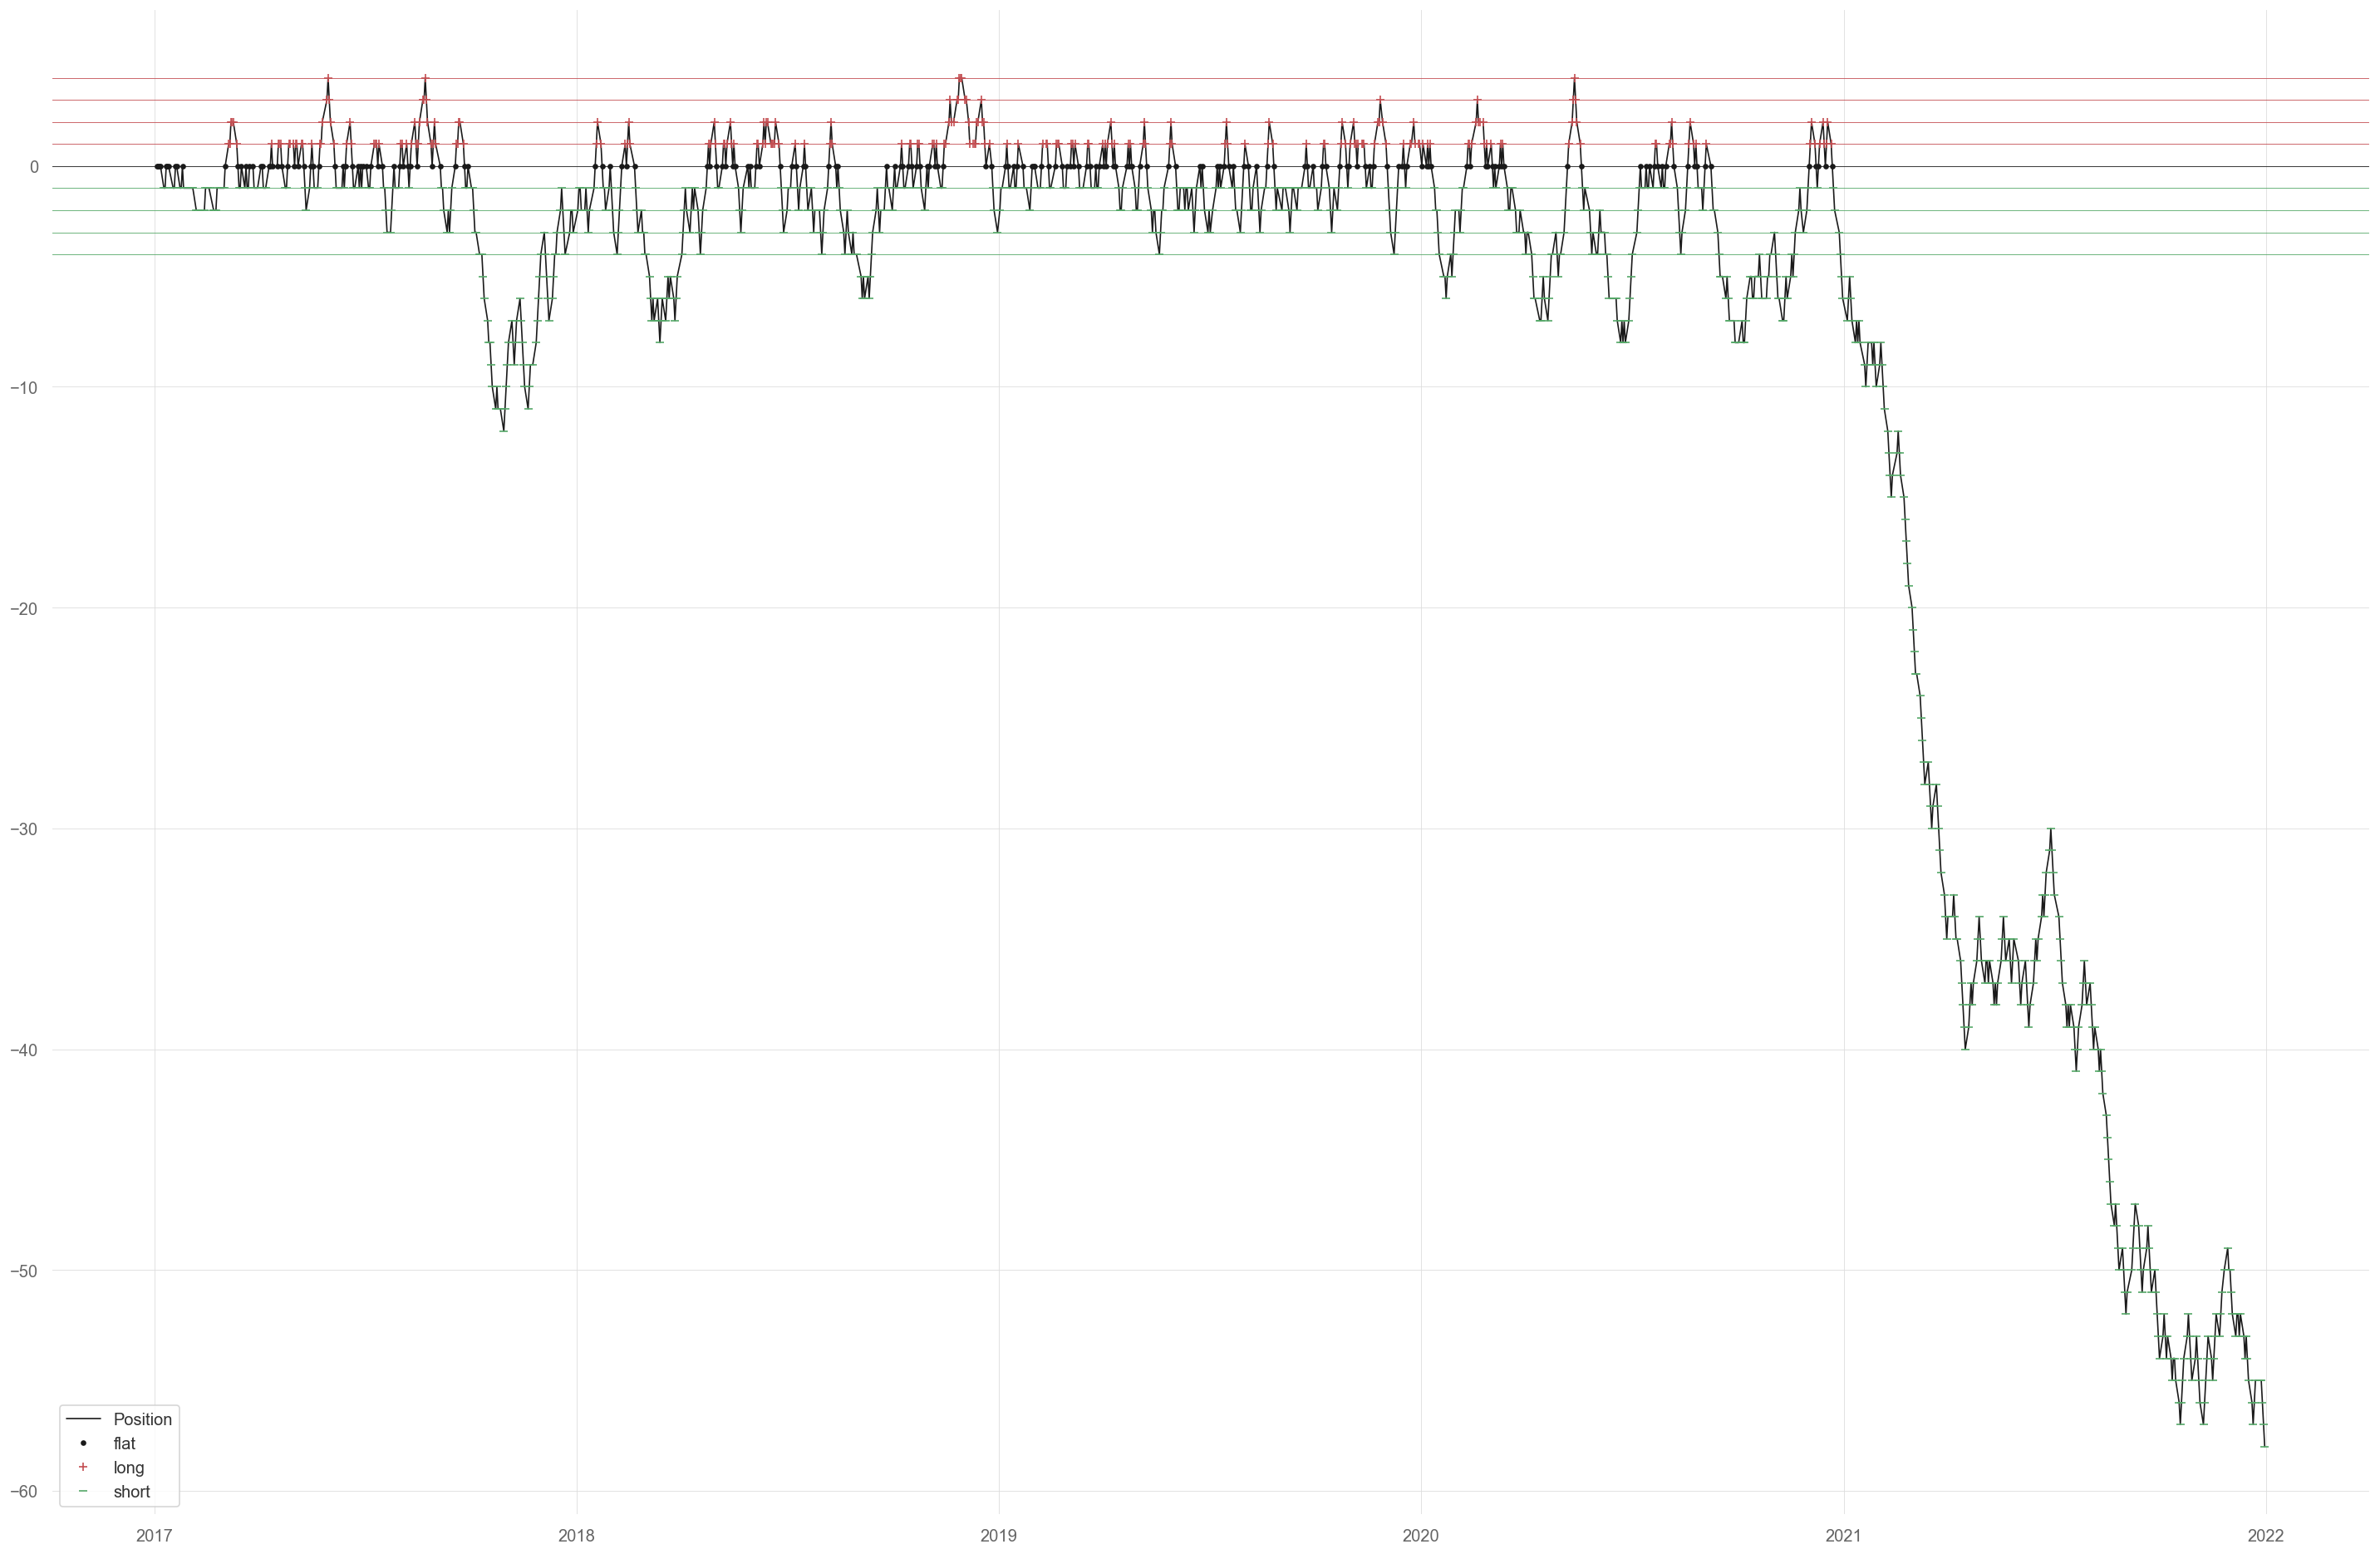

In [45]:
strategy_btc_gbtc.plot_positions()

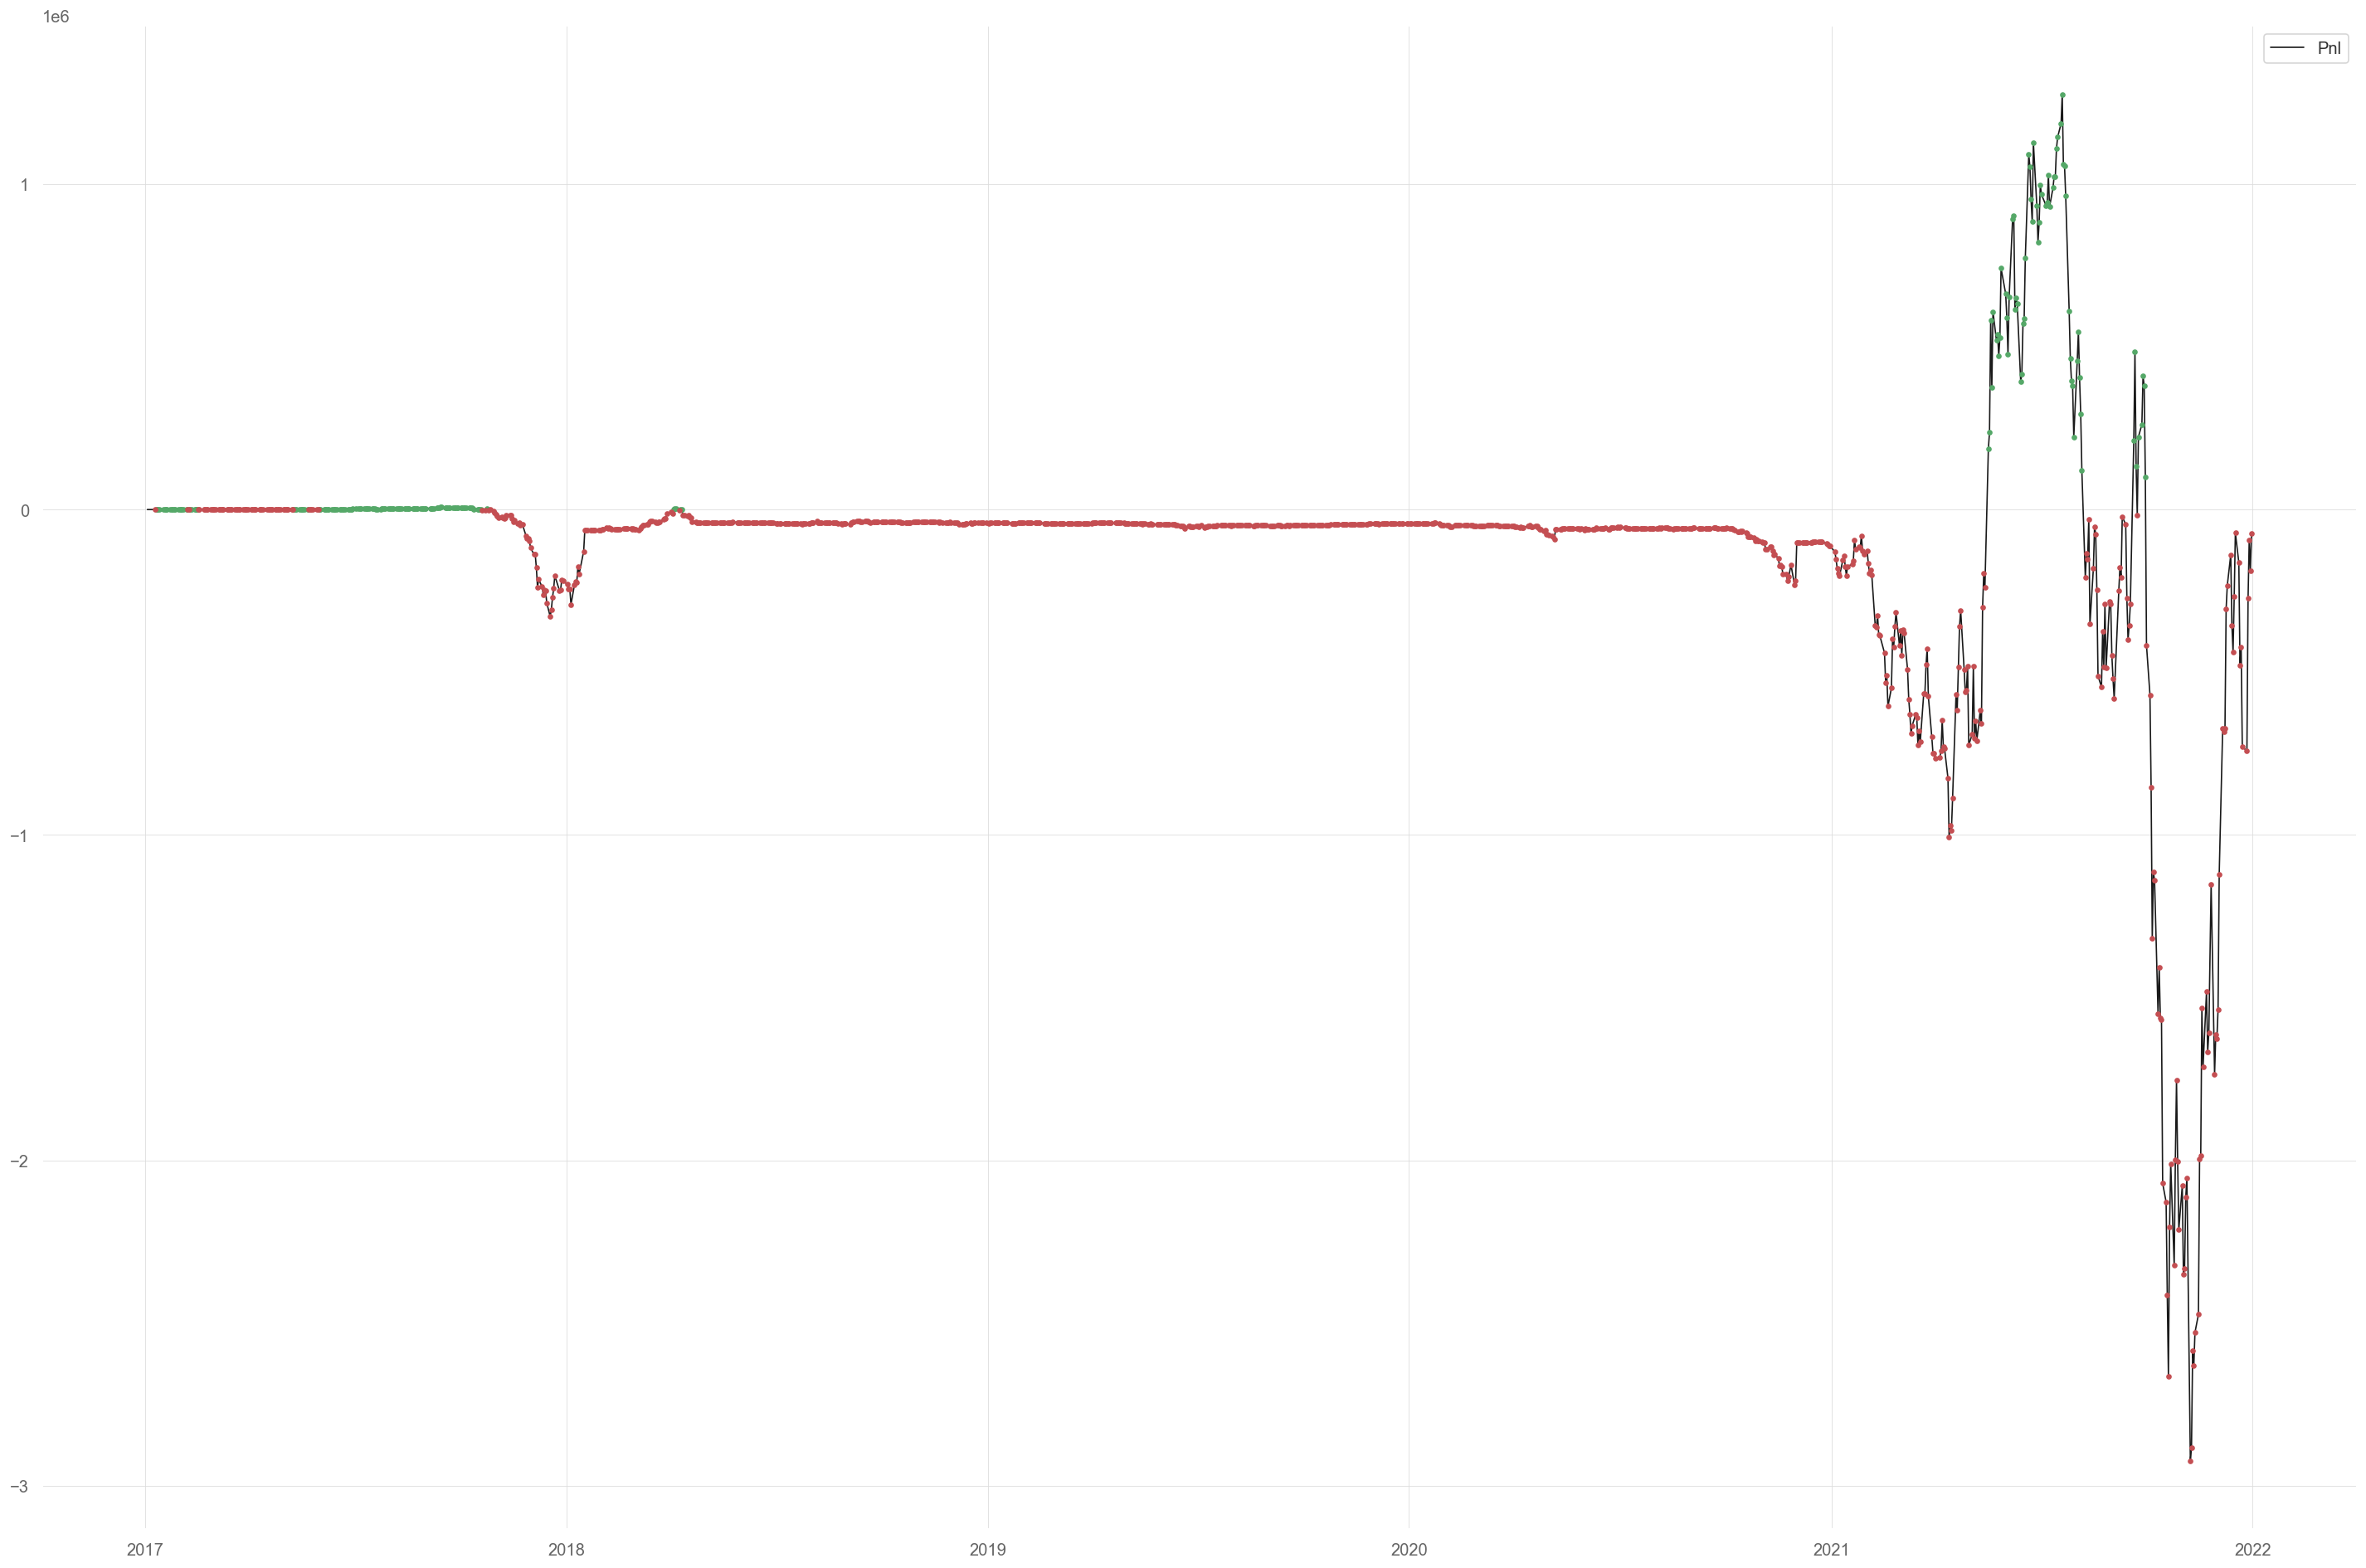

In [46]:
strategy_btc_gbtc.plot_pnl()

From these graphs and the previous ones, it is noticeable that, due to the significant variability in prices, the trading signal begins to have a lot of noise, causing large variations in positions and P&L. This may be due to the hyperparameters used in the strategy (buy/sell limits, price deviations from SMA, periods for calculating SMA, etc.). As mentioned earlier, with a proper adjustment of these parameters, the performance of the strategy could be improved.

In [47]:
strategy_btc_gbtc.delta_projected_actual_data.head()

ClosePrice  FinalStatArbTradingSignal  Trades  Position  Pnl
Date                                                                     
2017-01-03  1032.609053                   0.000000       0         0  0.0
2017-01-04  1134.496445                   0.000000       0         0  0.0
2017-01-05  1000.498129                  -9.882608       0         0  0.0
2017-01-06   892.463956                  -5.052492       0         0  0.0
2017-01-09   903.508667                 -22.043248      -1        -1  0.0

Let's select the events.

In [48]:
tEvents = strategy_btc_gbtc.delta_projected_actual_data['Trades'].loc[strategy_btc_gbtc.delta_projected_actual_data['Trades'] != 0]

In [49]:
tEvents

Date
2017-01-09   -1
2017-01-11    1
2017-01-17   -1
2017-01-19    1
2017-01-23   -1
             ..
2021-12-22    1
2021-12-23    1
2021-12-29   -1
2021-12-30   -1
2021-12-31   -1
Name: Trades, Length: 1030, dtype: int64

## 6. Metalabeling

Hasta aquí hemos obtenido el lado de la apuesta (columna Trades). Sin embargo, para aplicar nuestro modelo secundario, debemos generar una etiqueta para decidir si tomar la apuesta (1) o no (0), que es precisamente para lo que se entrenará el modelo. Dado que ya tenemos el lado, podemos distinguir entre la toma de ganancias o la pérdida de parada y así generar esta etiqueta.

For this, we define our necessary parameters: Profit Taking, Stop Loss, Target, and minimum considered return.

In [50]:
# Definimos las bandas de PT y SL.
ptSl = [0.5, 0.4]
# Computamos la volatilidad diaria, suavizada con una media
# movil pesada de 20 dias (arbitraria, acorde al aplicado en la estrategia de pairs trading, también se podria aprender)
target = labeling.getDailyVol(close=assets_data[TRADING_INSTRUMENT]['Close'], span0=20)
# Seleccionamos el mínimo retorno considerado.
minRet = 0.025
# Numero de CPUs para el procesamiento en paralelo. 
cpus = 4

Then, the vertical barrier time is defined.

In [51]:
# Definimos el tiempo de la barrera vertical. Esto es algo a optimizar
# y debe ajustarse en conjunto con los valores de retorno PT y SL.
num_days = 4

# Computamos las marcas temporales de la ventana. Para cada evento
# en tEvents (inicio de la ventana), obtenemos el final de la ventana.
# Nota: a diferencia de la notebook con labelling unicamente, tEvents 
#       aquí es una serie con el side de la apuesta por lo que debemos
#       pasar el indice a getVerticalBarrier() para reutilizar la funcion.
t1 = labeling.getVerticalBarrier(tEvents.index, assets_data[TRADING_INSTRUMENT]['Close'], numDays=num_days)
print("Barreras verticales para los eventos cruce de medias:")
print(t1)

Barreras verticales para los eventos cruce de medias:
Date
2017-01-09   2017-01-13
2017-01-11   2017-01-17
2017-01-17   2017-01-23
2017-01-19   2017-01-23
2017-01-23   2017-01-27
                ...    
2021-12-17   2021-12-21
2021-12-20   2021-12-27
2021-12-21   2021-12-27
2021-12-22   2021-12-27
2021-12-23   2021-12-27
Name: Date, Length: 1027, dtype: datetime64[ns]


Next, the triple barrier events are defined.

In [52]:
# Generamos los eventos de la triple frontera. En esta funcion obtenemos
# un dataframe cuyo indice es cuando ocurre el evento y tiene 2 columnas
# - t1: momento en el que sucede el evento.
# - trgt: retorno obtenido en ese momento.
triple_barrier_events = labeling.getEvents(assets_data[TRADING_INSTRUMENT]['Close'],tEvents.index,ptSl,target,minRet,cpus,t1=t1,side=tEvents)
print("Eventos de triple frontera y retorno obtenido: ")
print(triple_barrier_events)

Eventos de triple frontera y retorno obtenido: 
                   t1      trgt  side
Date                                 
2017-01-09 2017-01-11  0.121075  -1.0
2017-01-11 2017-01-17  0.098190   1.0
2017-01-17 2017-01-23  0.104227  -1.0
2017-01-19 2017-01-23  0.093122   1.0
2017-01-23 2017-01-27  0.080935  -1.0
...               ...       ...   ...
2021-12-22 2021-12-23  0.044499   1.0
2021-12-23 2021-12-27  0.043639   1.0
2021-12-29        NaT  0.048055  -1.0
2021-12-30        NaT  0.045710  -1.0
2021-12-31        NaT  0.043576  -1.0

[1005 rows x 3 columns]


2022-04-05 17:51:34.603396 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/mpfin.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in out:df0=df0.append(i)
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/mpfin.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in out:df0=df0.append(i)
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/mpfin.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in out:df0=df0.append(i)
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/u

Finally, the labels are obtained.

In [53]:
# Obtenemos los labels! Los labels nos dan la siguiente informacion:
# - Indice: momento en el que ocurre el evento segun nuestra estrategia.
# - Columna ret: el retorno que vamos a obtener.
# - Columna bin: lo que sucede con la señal de la apuesta:
#   - 1: se toma la apuesta.
#   - 0: no se toma la apuesta.
labels = labeling.getBins(triple_barrier_events, assets_data[TRADING_INSTRUMENT]['Close'])
print("Labels para triple frontera: ")
print(labels)

# Una pequeña tabla de contención que nos indica como se distribuyen
# los labels.
print(labels['bin'].value_counts())

Labels para triple frontera: 
                 ret  bin
Date                     
2017-01-09  0.127496  1.0
2017-01-11  0.149321  1.0
2017-01-17 -0.014446  0.0
2017-01-19  0.018677  1.0
2017-01-23 -0.001457  0.0
...              ...  ...
2021-12-17 -0.059299  0.0
2021-12-20 -0.045305  0.0
2021-12-21 -0.033228  0.0
2021-12-22  0.041503  1.0
2021-12-23  0.001645  1.0

[1002 rows x 2 columns]
0.0    522
1.0    480
Name: bin, dtype: int64


Here is the BTC series with the buy/trade signals.

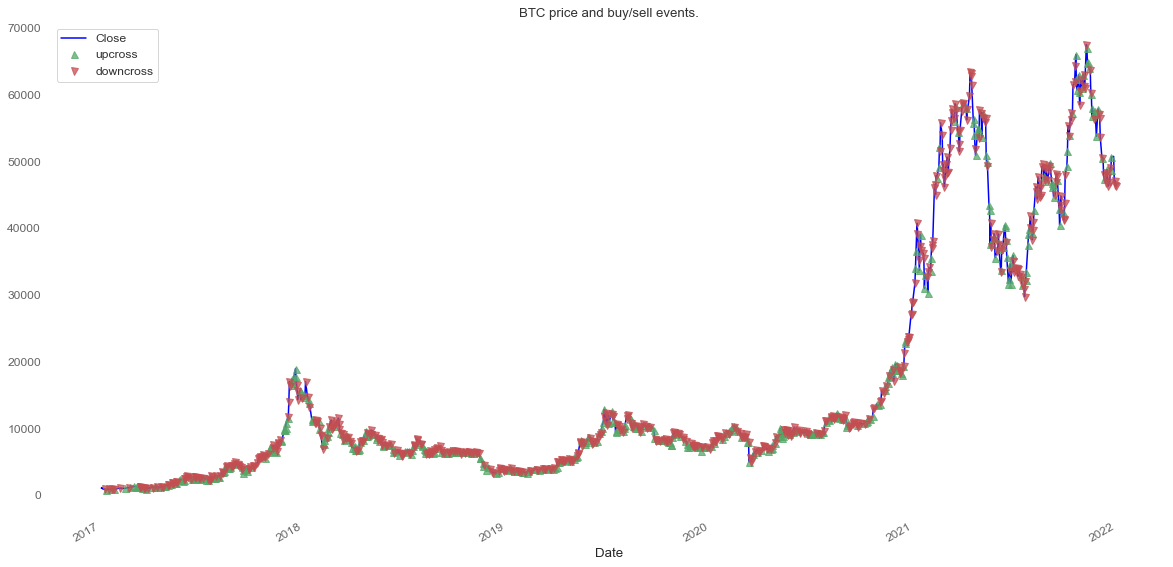

In [54]:
# Graficamos la serie de precios agregando unas flechas de color que indique
# el signo de la apuesta.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
assets_data[TRADING_INSTRUMENT].plot(kind='line',y='Close', color='blue', ax=ax)
assets_data[TRADING_INSTRUMENT].loc[tEvents[tEvents == 1].index].plot(
    ax=ax,ls='',marker='^', markersize=7, alpha=0.75, label='upcross', color='g', y='Close')
assets_data[TRADING_INSTRUMENT].loc[tEvents[tEvents == -1].index].plot(
    ax=ax,ls='',marker='v', markersize=7, alpha=0.75, label='downcross', color='r', y='Close')
plt.title('BTC price and buy/sell events.')
plt.grid()
plt.show()

## 7. Fractional Differentiation

So far, we have used the price series without differentiation. Let's try with the differentiated series. To do this, we need to find the optimal level of differentiation for each series.

/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: Th

        adfStat          pVal  lags    nObs  95% conf      corr
0.00  -1.328868  6.158639e-01   1.0  1257.0 -2.863842  1.000000
0.05  -1.474005  5.463293e-01   1.0  1217.0 -2.863918  0.999648
0.10  -1.884926  3.391855e-01   1.0  1196.0 -2.863960  0.997161
0.15  -2.128654  2.331497e-01   1.0  1186.0 -2.863980  0.990825
0.20  -2.441038  1.304872e-01   1.0  1185.0 -2.863982  0.980665
0.25  -2.872187  4.867924e-02   1.0  1187.0 -2.863978  0.966061
0.30  -3.334654  1.339874e-02   1.0  1192.0 -2.863968  0.947748
0.35  -4.045728  1.189114e-03   1.0  1197.0 -2.863958  0.923860
0.40  -4.900749  3.475742e-05   1.0  1203.0 -2.863946  0.896154
0.45  -5.612733  1.193265e-06   1.0  1209.0 -2.863934  0.862397
0.50  -6.814913  2.070960e-09   1.0  1214.0 -2.863924  0.818611
0.55  -7.959959  2.966832e-12   1.0  1219.0 -2.863914  0.765739
0.60  -9.363667  7.702300e-16   1.0  1224.0 -2.863904  0.705828
0.65 -11.023125  5.918785e-20   1.0  1228.0 -2.863896  0.635280
0.70 -12.783659  7.324431e-24   1.0  123

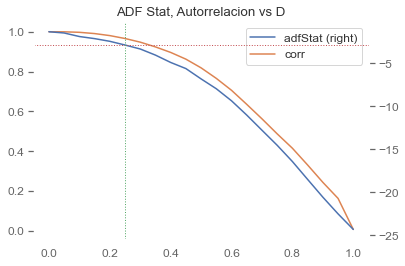

In [55]:
# Computo una lista de valores de d (el grado de diferenciación),
# y diferencio la serie de precios.
ds = np.linspace(0, 1, 21)
out = frac_diff.compute_multiple_ffd(assets_data[TRADING_INSTRUMENT]['Close'].to_frame(), 1e-3, ds)
print(out)

# Realizamos un plot para evaluar gráficamente el valor óptimo.
out[['adfStat','corr']].plot(secondary_y='adfStat')
mean_95conf = out['95% conf'].mean()
optim_d = frac_diff.get_d_optim(out, conf=0.05)
plt.axhline(mean_95conf,linewidth=1,color='r',linestyle='dotted')
plt.axvline(optim_d,linewidth=1,color='g',linestyle='dotted')
plt.grid()
plt.title('ADF Stat, Autorrelacion vs D')
print('Promedio de valores críticos para el estadístico al 5%: {}'.format(mean_95conf))
print('Valor óptimo de d: {}'.format(optim_d))

We apply fractional differentiation to the BTC and ETH series and add them to the dataset.

In [56]:
def ffd_optim_sample(ds, input_df, threshold=1e-3):
    out = frac_diff.compute_multiple_ffd(input_df.to_frame(), threshold, ds)
    optim_d = frac_diff.get_d_optim(out, conf=0.05)
    return optim_d, frac_diff.fracDiff_FFD(input_df.to_frame(), d=optim_d, thres=threshold)

In [57]:

for asset in SYMBOLS:
    optim_d, assets_data[asset]['CloseFFD'] = ffd_optim_sample(ds, assets_data[asset]['Close'], threshold=1e-3)
    print(f"El d óptimo para el activo {asset} es {optim_d}")

/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: Th

El d óptimo para el activo BTC es 0.25


/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_ = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/frac_diff.py:88: FutureWarning: Th

El d óptimo para el activo GBTC es 0.15000000000000002


It is observed that the optimal differentiation value is 0.25 for BTC and 0.15 for GBTC.

Next, we plot the differentiated series.

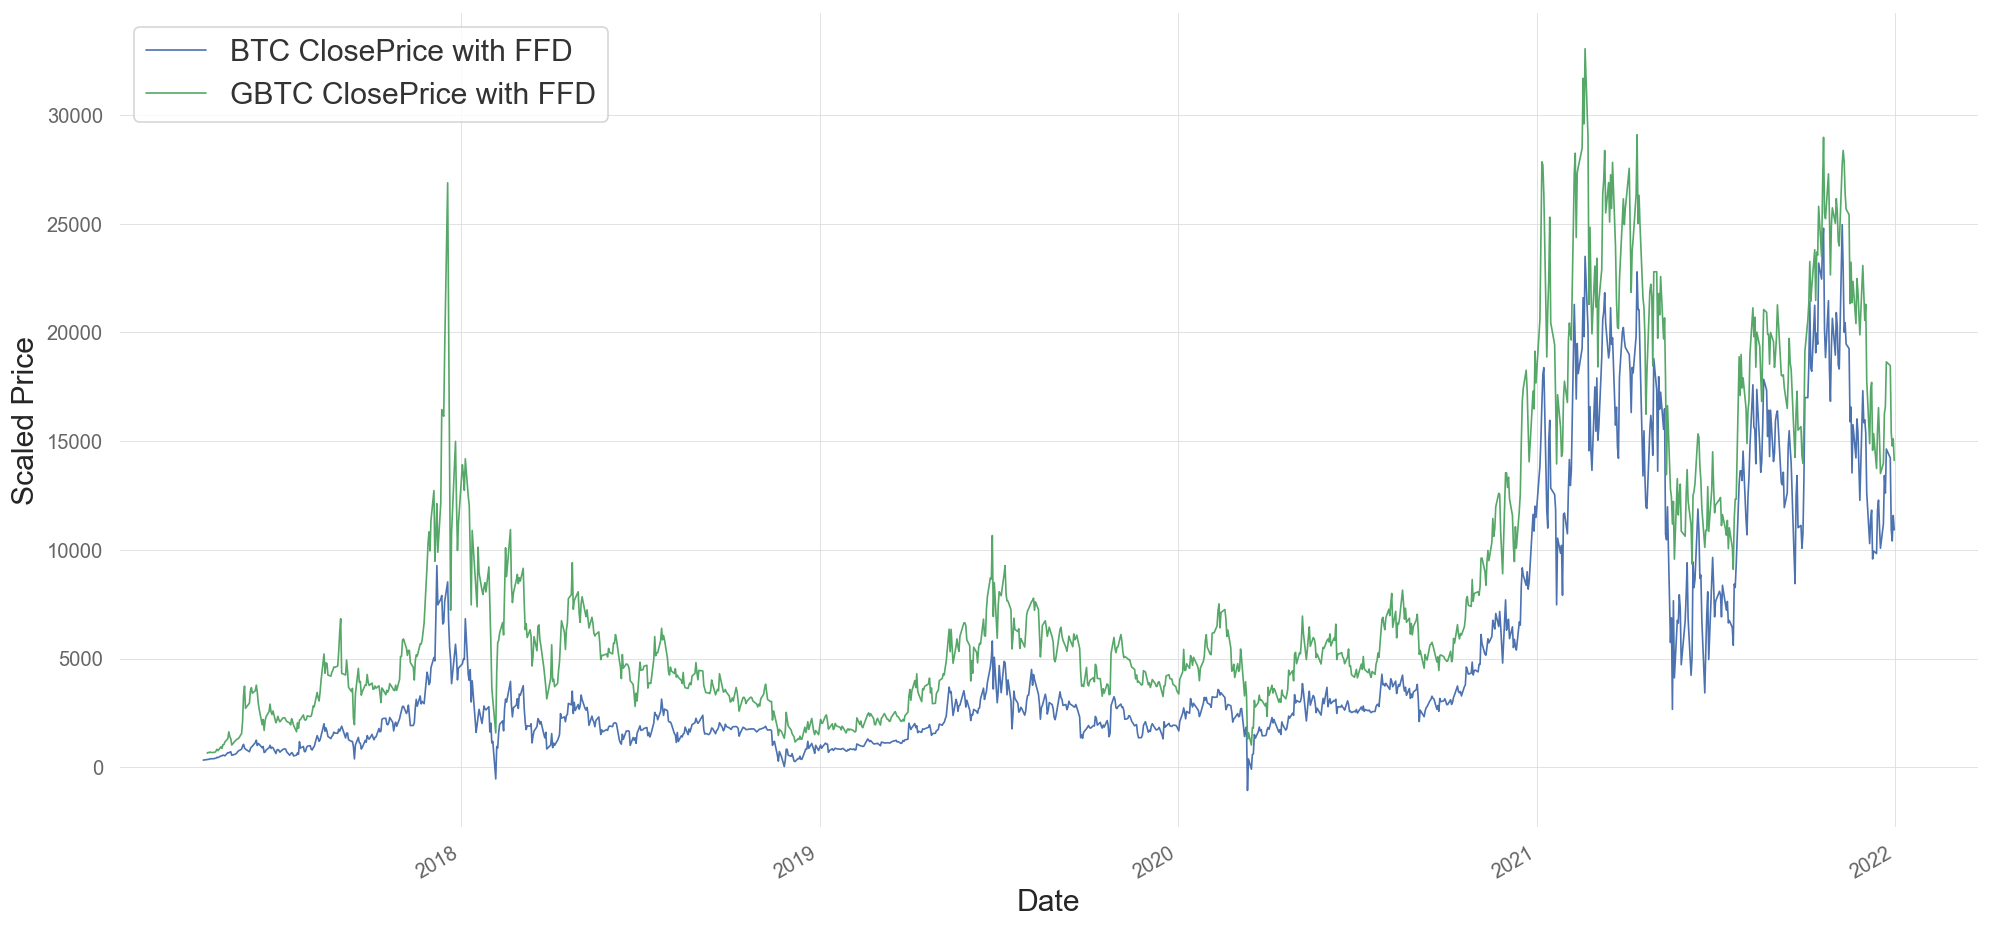

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10), dpi=120)
cycol = cycle('bgrcmky')

price_data = pd.DataFrame()
for symbol in SYMBOLS:

  multiplier = 1.0
  if symbol == 'ETH':
    multiplier = 10.0
  if symbol == 'GBTC':
    multiplier = 1000.0

  label = symbol + ' ClosePrice with FFD'
  price_data = price_data.assign(label=pd.Series(assets_data[symbol]['CloseFFD'] * multiplier, index=assets_data[symbol].index))
  ax = price_data['label'].plot(color=next(cycol), lw=1., label=label)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Scaled Price', fontsize=18)
plt.legend(prop={'size': 18})
plt.show()

### 7.1. Volatilities

In [59]:
# Compute daily volatility, smoothed with a 50-day weighted moving average (arbitrary, could also be learned)
daily_vol = {}
for asset in SYMBOLS:
    daily_vol[asset] = labeling.getDailyVol(close=assets_data[asset]['CloseFFD'], span0=50)

In [60]:
# Min, avg, and max volatility.
for asset in daily_vol:
    print(f"Volatilidades de {asset}")
    print(f"Volatilidad mínima: {daily_vol[asset].min()}")
    print(f"Volatilidad media: {daily_vol[asset].mean()}")
    print(f"Volatilidad máxima: {daily_vol[asset].max()}")

Volatilidades de BTC
Volatilidad mínima: 0.01563362657032597
Volatilidad media: 0.44075194082468333
Volatilidad máxima: 4.6188957635431604
Volatilidades de GBTC
Volatilidad mínima: 0.003034276255438999
Volatilidad media: 0.17226236456654687
Volatilidad máxima: 0.5893917991346431


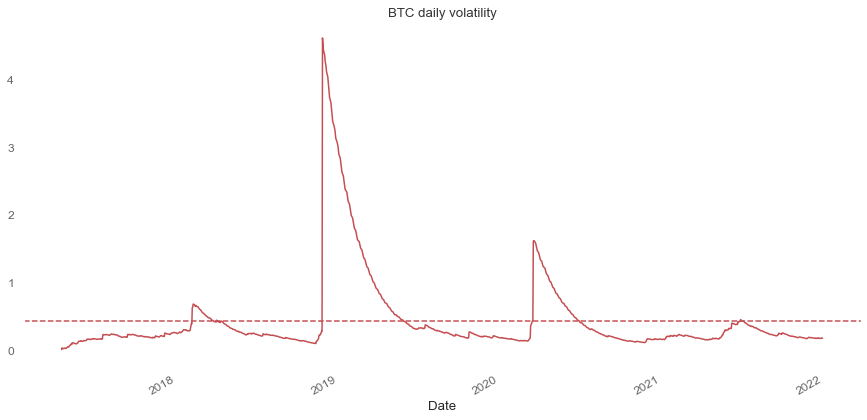

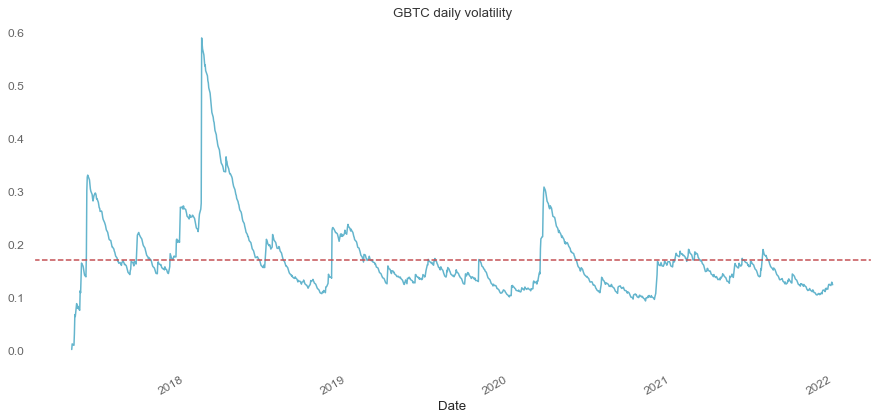

In [61]:
# We plot the volatility over the history of BTC. The red line shows the average value.
for asset in SYMBOLS:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))    
    daily_vol[asset].plot(kind='line',y='dailyVol', color=next(cycol), ax=ax)
    ax.axhline(daily_vol[asset].mean(),ls='--',color='r')
    plt.title(f"{asset} daily volatility")
    plt.grid()
    plt.show()

It is observed that the volatility does not improve compared to the original situation.

### 7.2. Labeling

#### 7.2.1. Implementation of *pairs trading*

Let's run the *pairs trading* strategy again.

In [62]:
strategy_btc_eth_gbtc_with_ffd = pairs_trading.PairsTradingStrategy(TRADING_INSTRUMENT, SYMBOLS, assets_data)
strategy_btc_eth_gbtc_with_ffd.init_parameters(num_days=len(assets_data[TRADING_INSTRUMENT].index), SMA_NUM_PERIODS=5, PRICE_DEV_NUM_PRICES=50)
strategy_btc_eth_gbtc_with_ffd.init_thresholds()
strategy_btc_eth_gbtc_with_ffd.run_strategy(column='CloseFFD')

Buy  1  @  698.2455513215489 Position:  1
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Sell  1  @  817.6394641988543 Position:  0
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
Sell  1  @  854.9726953828076 Position:  -1
OpenPnL:  0  ClosedPnL:  119.39391287730541  TotalPnL:  119.39391287730541
Buy  1  @  712.8524433980297 Position:  0
OpenPnL:  26.00972920434242  ClosedPnL:  119.39391287730541  TotalPnL:  145.40364208164783
Buy  1  @  556.8644501549913 Position:  1
OpenPnL:  0  ClosedPnL:  261.51416486208336  TotalPnL:  261.51416486208336
Sell  1  @  679.2151900758895 Position:  0
OpenPnL:  48.72510412003771  ClosedPnL:  261.51416486208336  TotalPnL:  310.2392689821211
Buy  1  @  523.4437918803087 Position:  1
OpenPnL:  0  ClosedPnL:  383.8649047829815  TotalPnL:  383.8649047829815
Sell  1  @  560.4255804331146 Position:  0
OpenPnL:  0.0  ClosedPnL:  383.8649047829815  TotalPnL:  383.8649047829815
Sell  1  @  662.5896877948649 Position:  -1
OpenPnL:  0  ClosedPnL:  420.84669333578745  Total

#### 7.2.2. Analysis of the strategy

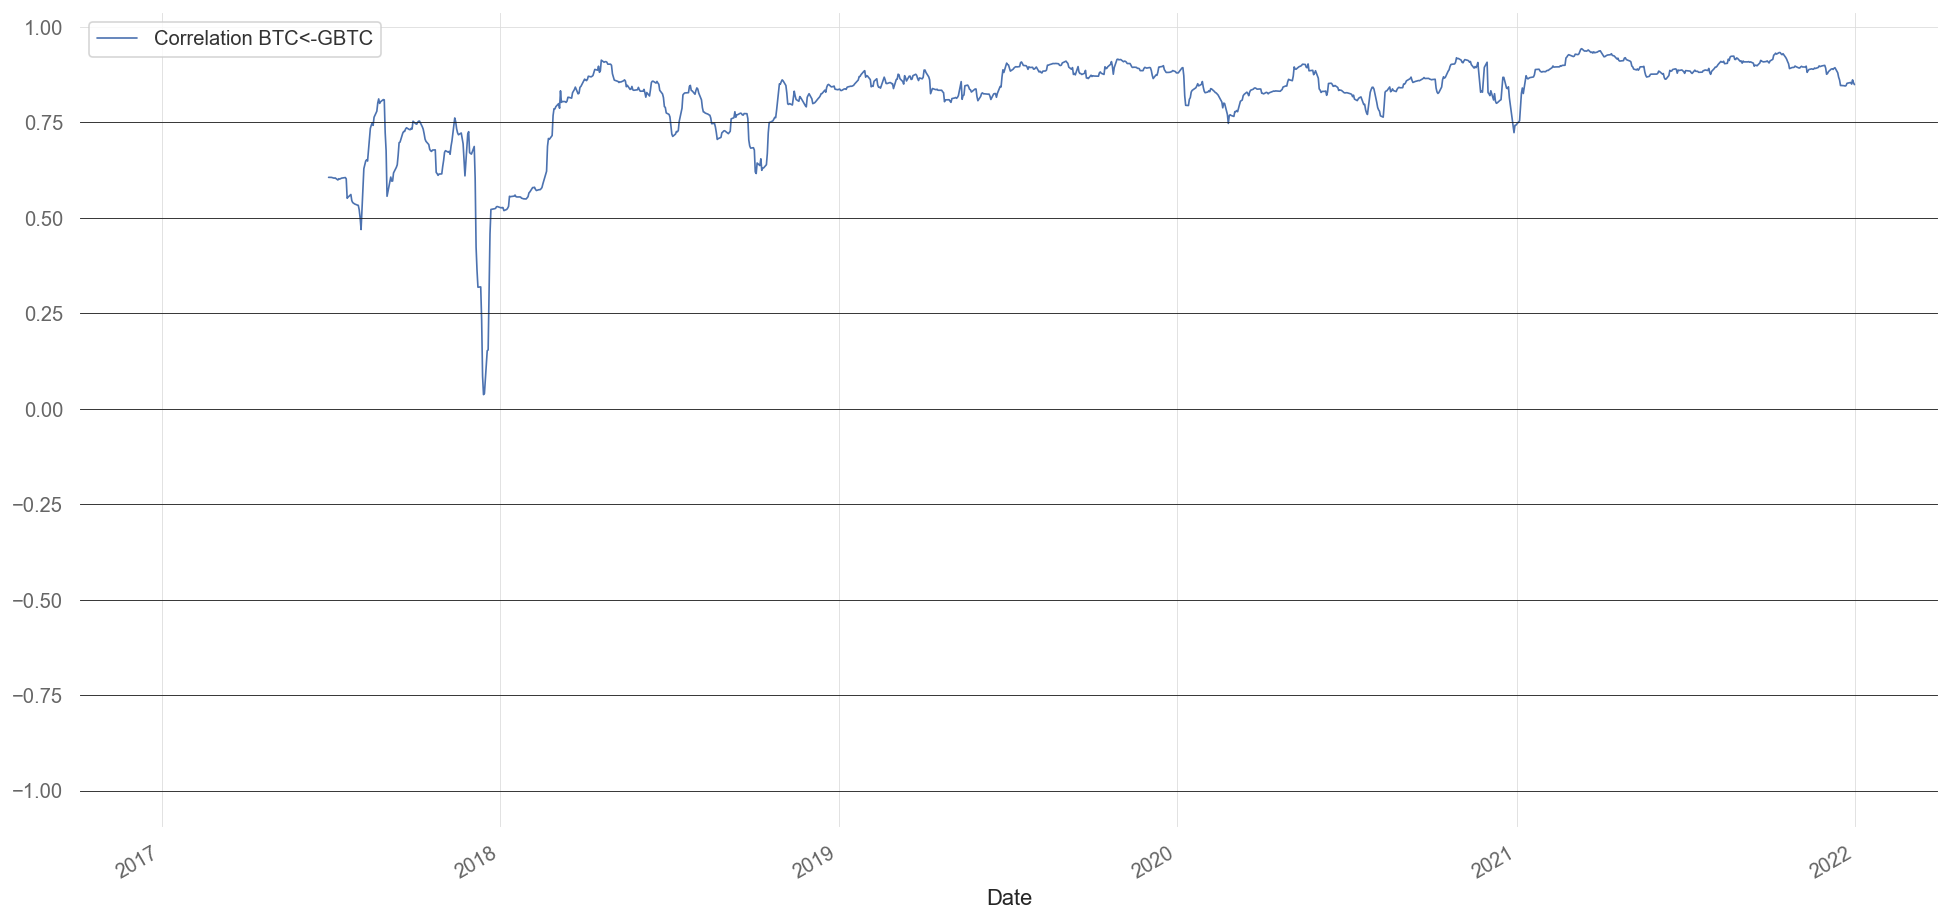

In [63]:
strategy_btc_eth_gbtc_with_ffd.plot_correlations()

There is no improvement in correlation compared to the one performed without differentiation. In fact, the low correlation at the end of 2017 is accentuated.

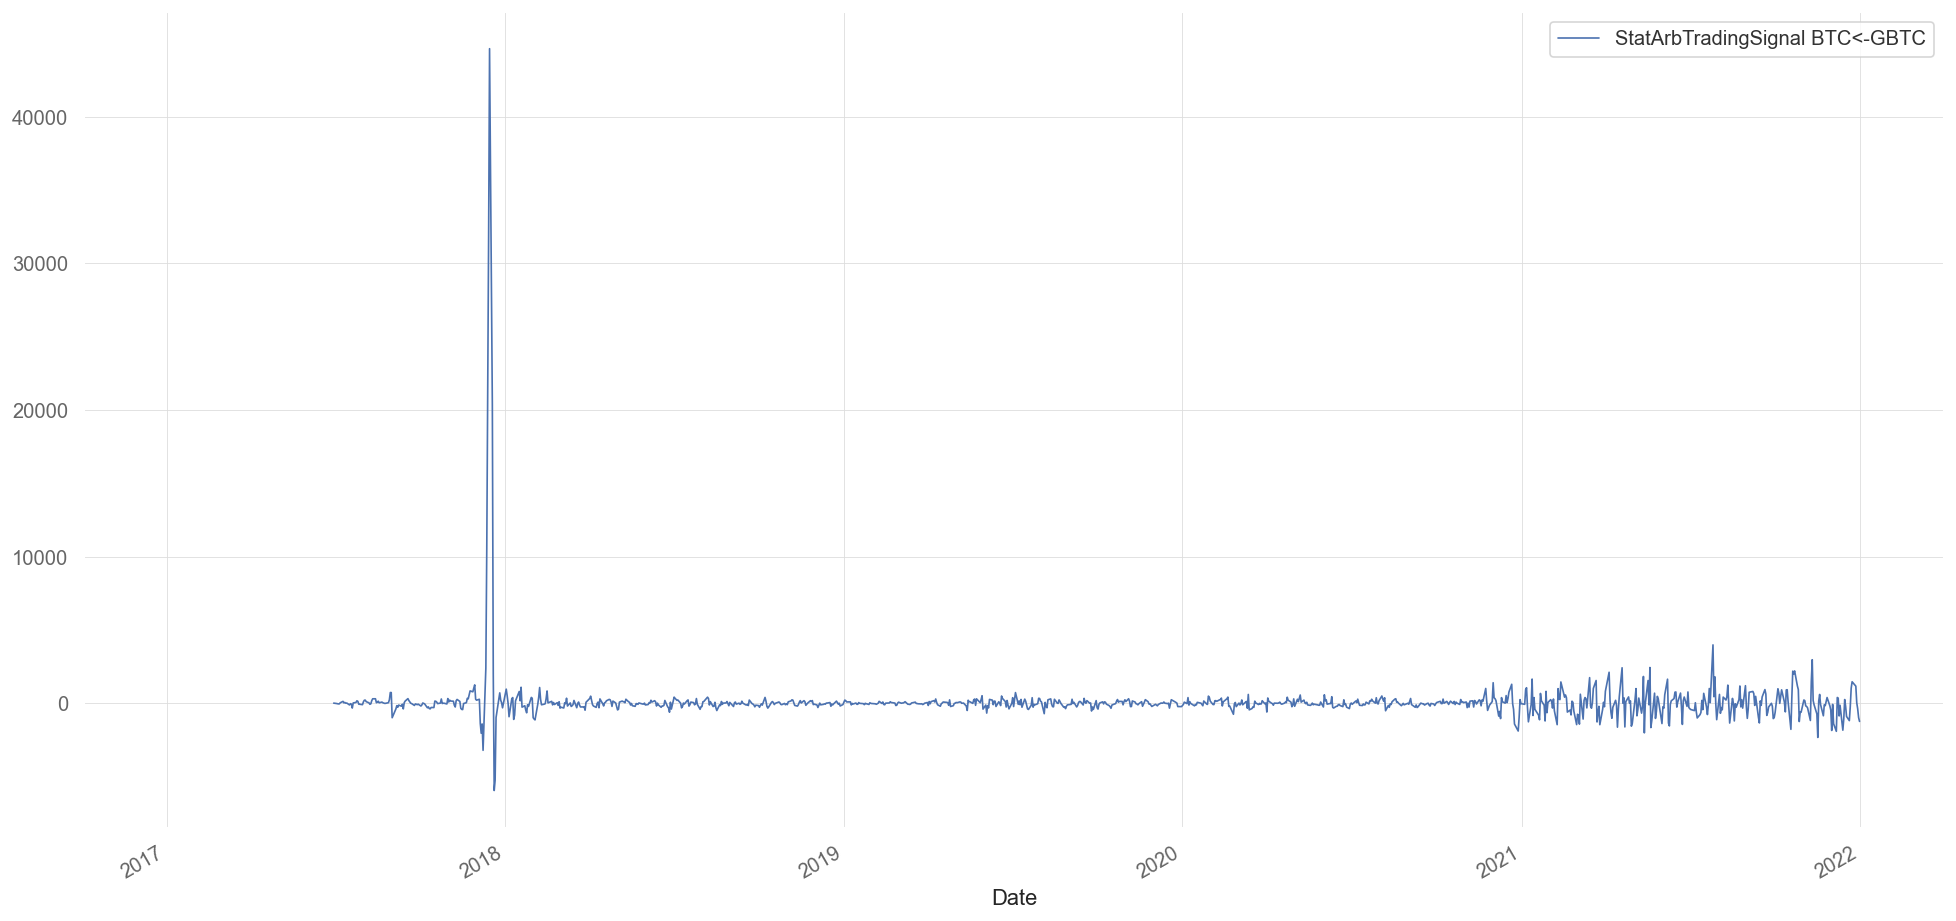

In [64]:
strategy_btc_eth_gbtc_with_ffd.plot_trading_signal()

The decision is made to continue with the series without differentiation.

## 7. Uniqueness

The next step is to apply uniqueness to our series. In this case, we apply Average Uniqueness. Other weights can also be added, such as Time Decay.

In [65]:
# Obtain the concurrency coefficients for each event.
numCoEvents = mpfin.mpPandasObj(sample_weights.mpNumCoEvents,('molecule',triple_barrier_events.index),cpus,
                          closeIdx=assets_data[TRADING_INSTRUMENT].index,t1=triple_barrier_events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(assets_data[TRADING_INSTRUMENT]['Close'].index).fillna(0)

# Generate a DataFrame containing in one column the weights by concurrency and in another column the weights by concurrency + returns.
out=pd.DataFrame()
out['tW'] = mpfin.mpPandasObj(sample_weights.mpSampleTW,('molecule',triple_barrier_events.index),cpus,
                        t1=triple_barrier_events['t1'],numCoEvents=numCoEvents)
out['w'] = mpfin.mpPandasObj(sample_weights.mpSampleW,('molecule',triple_barrier_events.index),cpus,
                       t1=triple_barrier_events['t1'],numCoEvents=numCoEvents,close=assets_data[TRADING_INSTRUMENT]['Close'])
out['w'] *= out.shape[0]/out['w'].sum()
averageUniqueness = out.mean()[0]
print("Dataframe de concurrencia de eventos en ventanas de triple frontera: ")
print(out)
print("Average uniqueness: ")
print(averageUniqueness)

2022-04-05 17:51:59.423177 100.0% mpNumCoEvents done after 0.0 minutes. Remaining 0.0 minutes.
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/mpfin.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(out[0],pd.Series):df0=pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/mpfin.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in out:df0=df0.append(i)
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/mpfin.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in out:df0=df0.append(i)
/Users/agustin/Documents/agustin/workspa

Dataframe de concurrencia de eventos en ventanas de triple frontera: 
                  tW         w
2017-01-09  0.833333  2.077830
2017-01-11  0.750000  0.901737
2017-01-17  0.566667  1.329213
2017-01-19  0.444444  0.637068
2017-01-23  0.500000  0.474415
...              ...       ...
2021-12-22  0.416667  0.366459
2021-12-23  0.666667  0.582191
2021-12-29  0.611111  0.924244
2021-12-30  0.416667  0.054568
2021-12-31  0.333333  0.204218

[1005 rows x 2 columns]
Average uniqueness: 
0.4301028192371476


/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/sample_weights.py:56: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wght=pd.Series(index=molecule)
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/sample_weights.py:56: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wght=pd.Series(index=molecule)
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/sample_weights.py:56: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  wght=pd.Series(index=molecule)
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/

In [66]:
# Generate a DataFrame between the concurrencies and the daily returns.
coEvents_std = (pd.DataFrame().assign(numCoEvents = numCoEvents, std = target))
print("Dataframe de concurrencia de eventos en ventanas de triple frontera y volatilidad")
print(coEvents_std)
print(coEvents_std.loc[:, "numCoEvents"].value_counts())

Dataframe de concurrencia de eventos en ventanas de triple frontera y volatilidad
            numCoEvents       std
Date                             
2017-01-03          0.0       NaN
2017-01-04          0.0       NaN
2017-01-05          0.0       NaN
2017-01-06          0.0  0.128865
2017-01-09          1.0  0.121075
...                 ...       ...
2021-12-27          1.0  0.041509
2021-12-28          0.0  0.043586
2021-12-29          1.0  0.048055
2021-12-30          2.0  0.045710
2021-12-31          3.0  0.043576

[1259 rows x 2 columns]
2.0    596
3.0    352
1.0    155
4.0     91
0.0     55
5.0     10
Name: numCoEvents, dtype: int64


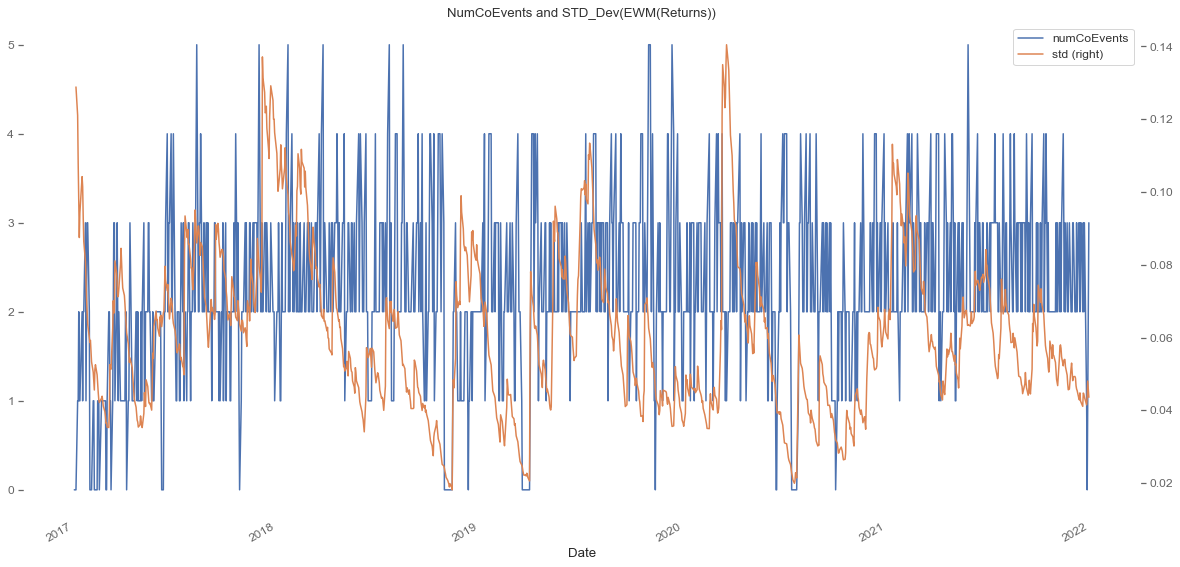

In [67]:
# Evaluate the returns and concurrencies in the time series.
fig, ax = plt.subplots(figsize=(20,10))
coEvents_std['numCoEvents'].plot(legend=True, ax=ax)
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax)
plt.title('NumCoEvents and STD_Dev(EWM(Returns))')
plt.grid()
plt.show()

Here we observe the co-occurrence of events during periods of high volatility.

## 7. Secondary Model

Next, the secondary model is computed to define the size of the bet.

First, the parameters of the model are prepared.

In [68]:
# Prepare the information to input it into a ML model.
Xy = (pd.merge_asof(triple_barrier_events, labels[['bin']],
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
Xy = (pd.merge_asof(Xy, out.loc[Xy.index].w,
                    left_index=True, right_index=True, 
                    direction='forward').dropna())

X = Xy.copy()[['trgt', 'side', 'w']].values
y = Xy.copy().bin.values # labels.bin.values
# Make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

### 7.1. Random Forest base

Then, we use a base model, applying it to our series without uniqueness applied.

In [69]:
# Hyperparameters
n_estimator = 400     # Number of trees.
criterion = 'entropy' # It is a classifier, need to define metric of the model
                      # to optimize. Other option could be gini.
max_depth = 2         # Number of levels for each tree. When selecting a binary split
                      # we let the training to be slower.
n_jobs = 4            # Number of threads that will be opened to train faster.
# To get more parameters, check https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                            criterion=criterion, n_jobs=n_jobs, random_state=123)
rf.fit(X_train[:,0:2], y_train)

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=400,
                       n_jobs=4, random_state=123)

Classification report
              precision    recall  f1-score   support

         0.0       0.56      0.58      0.57       425
         1.0       0.51      0.48      0.49       377

    accuracy                           0.53       802
   macro avg       0.53      0.53      0.53       802
weighted avg       0.53      0.53      0.53       802

Accuracy
0.5349127182044888


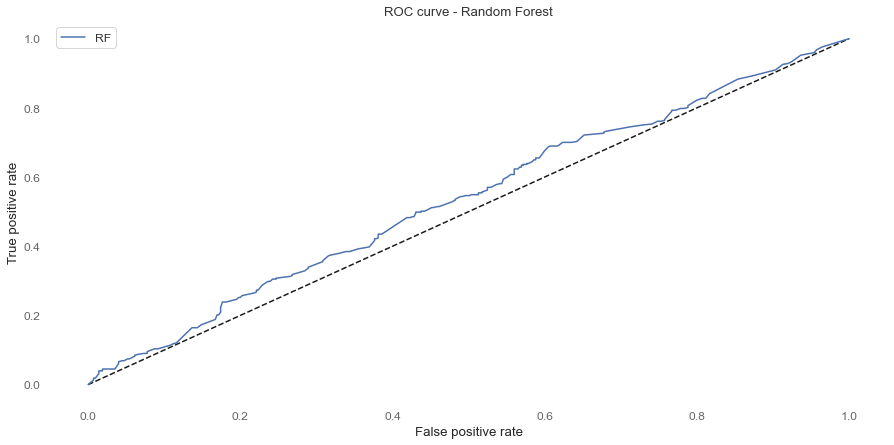

In [70]:
# Predecimos con el test set y contrastamos.
y_pred_rf_prob = rf.predict_proba(X_test[:,0:2])[:, 1]
y_pred_rf = rf.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
print("Classification report")
print(classification_report(y_test, y_pred_rf))

print("Accuracy")
print(accuracy_score(y_test, y_pred_rf))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest')
plt.legend(loc='best')
plt.grid()
plt.show()

### 7.2. Random Forest with Uniqueness

Let's now test the model with uniqueness applied.

In [71]:
# Hyperparameters
n_estimator = 400     # Number of trees.
criterion = 'entropy' # It is a classifier, need to define metric of the model
                      # to optimize. Other option could be gini.
max_depth = 2         # Number of levels for each tree. When selecting a binary split
                      # we let the training to be slower.
n_jobs = 4            # Number of threads that will be opened to train faster.
# To get more parameters, check https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

rf2 = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                             criterion=criterion, n_jobs=n_jobs, random_state=123)
rf2.fit(X_train[:,0:2], y_train, sample_weight=X_train[:,2])

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=400,
                       n_jobs=4, random_state=123)

Classification report
              precision    recall  f1-score   support

         0.0       0.57      0.45      0.50       425
         1.0       0.50      0.61      0.55       377

    accuracy                           0.52       802
   macro avg       0.53      0.53      0.52       802
weighted avg       0.53      0.52      0.52       802

Accuracy
0.5249376558603491


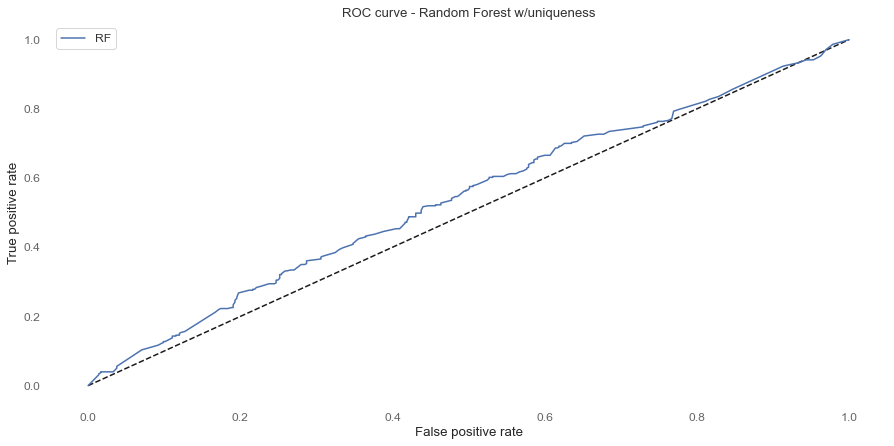

In [72]:
# Predict using the test set and compare the results.
y_pred_rf2_prob = rf2.predict_proba(X_test[:,0:2])[:, 1]
y_pred_rf2 = rf2.predict(X_test[:,0:2])

# Generate a classification report and create an ROC curve.
fpr_rf2, tpr_rf2, _ = roc_curve(y_test, y_pred_rf2_prob)
print("Classification report")
print(classification_report(y_test, y_pred_rf2))

print("Accuracy")
print(accuracy_score(y_test, y_pred_rf2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf2, tpr_rf2, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest w/uniqueness')
plt.legend(loc='best')
plt.grid()
plt.show()

In this case, uniqueness does not improve the model performance.

### 7.3. Bagging base

Next, we use Bagging without uniqueness applied. Some hyperparameters have been tuned for better adjustment.

In [73]:
# Hyperparameters
n_estimator = 500     # Numero de arboles.
max_samples = 0.5     # Portion of the dataset to sample for each tree.
criterion = 'entropy' # It is a classifier, need to define metric of the model
                      # to optimize. Other option could be gini.
n_jobs = 4            #  Number of threads that will be opened to train faster.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123)
bc.fit(X_train[:,0:2], y_train)

BaggingClassifier(max_samples=0.5, n_estimators=500, n_jobs=4, random_state=123)

Classification report
              precision    recall  f1-score   support

         0.0       0.55      0.59      0.57       425
         1.0       0.49      0.45      0.47       377

    accuracy                           0.52       802
   macro avg       0.52      0.52      0.52       802
weighted avg       0.52      0.52      0.52       802

Accuracy
0.5224438902743143


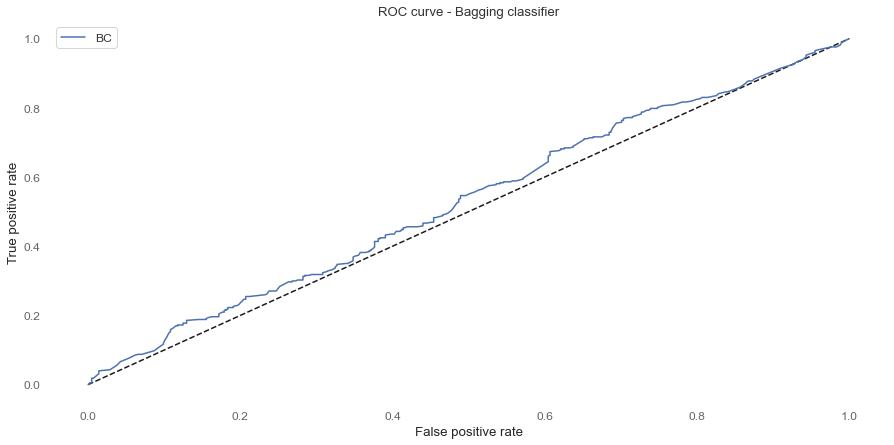

In [74]:
# Predict using the test set and compare the results.
y_pred_bc_prob = bc.predict_proba(X_test[:,0:2])[:, 1]
y_pred_bc = bc.predict(X_test[:,0:2])

# Generate a classification report and create an ROC curve.
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc_prob)
print('Classification report')
print(classification_report(y_test, y_pred_bc))

print("Accuracy")
print(accuracy_score(y_test, y_pred_bc))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label='BC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bagging classifier')
plt.legend(loc='best')
plt.grid()
plt.show()

### 7.4. Bagging with Uniqueness

Similarly, we try Bagging with uniqueness applied. Initially, we use max_samples = average uniqueness.

In [75]:
# Hyperparameters
n_estimator = 400     # Number of trees.
max_samples = averageUniqueness     # Portion of the dataset to sample for each tree.
criterion = 'entropy' # It is a classifier, need to define metric of the model
                      # to optimize. Other option could be gini.
n_jobs = 4            #  Number of threads that will be opened to train faster.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc2 = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123)
bc2.fit(X_train[:,0:2], y_train)

BaggingClassifier(max_samples=0.4301028192371476, n_estimators=400, n_jobs=4,
                  random_state=123)

Classification report
              precision    recall  f1-score   support

         0.0       0.55      0.59      0.57       425
         1.0       0.49      0.45      0.47       377

    accuracy                           0.52       802
   macro avg       0.52      0.52      0.52       802
weighted avg       0.52      0.52      0.52       802

Accuracy
0.5224438902743143


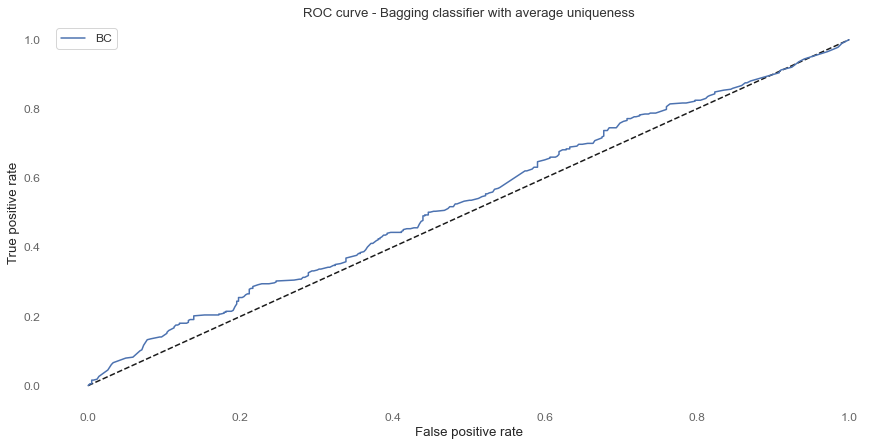

In [76]:
# Predict using the test set and compare the results.
y_pred_bc2_prob = bc2.predict_proba(X_test[:,0:2])[:, 1]
y_pred_bc2 = bc2.predict(X_test[:,0:2])

# Generate a classification report and create an ROC curve.
fpr_bc2, tpr_bc2, _ = roc_curve(y_test, y_pred_bc2_prob)
print("Classification report")
print(classification_report(y_test, y_pred_bc2))

print("Accuracy")
print(accuracy_score(y_test, y_pred_bc2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc2, tpr_bc2, label='BC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bagging classifier with average uniqueness')
plt.legend(loc='best')
plt.grid()
plt.show()

Probamos nuevamente, con max_samples = 0.5

In [77]:
# Hyperparameters
n_estimator = 400     # Number of trees.
max_samples = 0.5     # Portion of the dataset to sample for each tree.
criterion = 'entropy' # It is a classifier, need to define metric of the model
                      # to optimize. Other option could be gini.
n_jobs = 4            # Number of threads that will be opened to train faster.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc3 = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123)
bc3.fit(X_train[:,0:2], y_train, sample_weight=X_train[:,2])

BaggingClassifier(max_samples=0.5, n_estimators=400, n_jobs=4, random_state=123)

Classification report
              precision    recall  f1-score   support

         0.0       0.55      0.59      0.57       425
         1.0       0.49      0.45      0.47       377

    accuracy                           0.52       802
   macro avg       0.52      0.52      0.52       802
weighted avg       0.52      0.52      0.52       802

Accuracy
0.5224438902743143


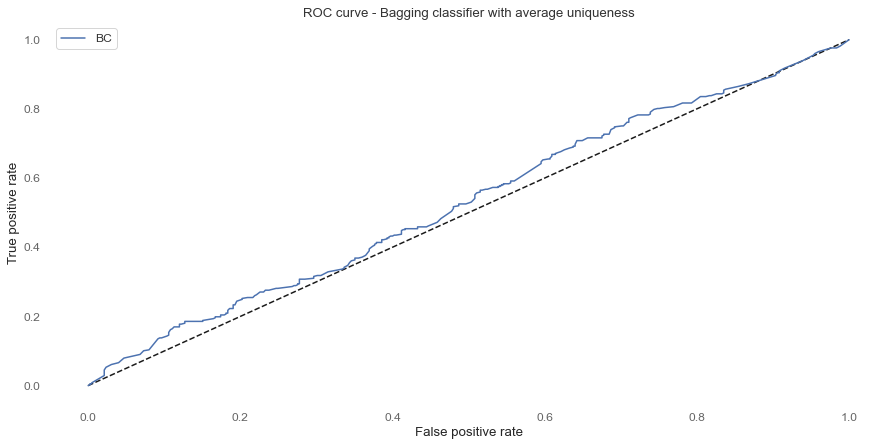

In [78]:
# Predict using the test set and compare the results.
y_pred_bc3_prob = bc3.predict_proba(X_test[:,0:2])[:, 1]
y_pred_bc3 = bc3.predict(X_test[:,0:2])

# Generate a classification report and create an ROC curve.
fpr_bc3, tpr_bc3, _ = roc_curve(y_test, y_pred_bc3_prob)
print("Classification report")
print(classification_report(y_test, y_pred_bc3))

print("Accuracy")
print(accuracy_score(y_test, y_pred_bc3))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc3, tpr_bc3, label='BC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bagging classifier with average uniqueness')
plt.legend(loc='best')
plt.grid()
plt.show()

Testing with various models, we did not detect a significant improvement in the models' performance.

## 8. Cross-Validation

### 8.1. Hyperparameter Optimization

When evaluating the models, the metric to use is log-loss instead of accuracy, as in this case, the probabilities of the labels are used rather than the label itself.
On the other hand, regarding hyperparameter optimization, RandomSearch adjusts models by randomly traversing a given space of hyperparameters, while GridSearch performs this adjustment in an absolute manner, with a list of possible values for those hyperparameters.
In general, RandomSearch is usually used to traverse a wide range of values and thus adjust the search range. Once that range is obtained, a more detailed traversal can be done using GridSearch.

### 8.2. Base Cross-Validation

Firstly, traditional cross-validation is performed. The optimized hyperparameters from the previous section were used.

In [79]:
CV_SPLITS = 5

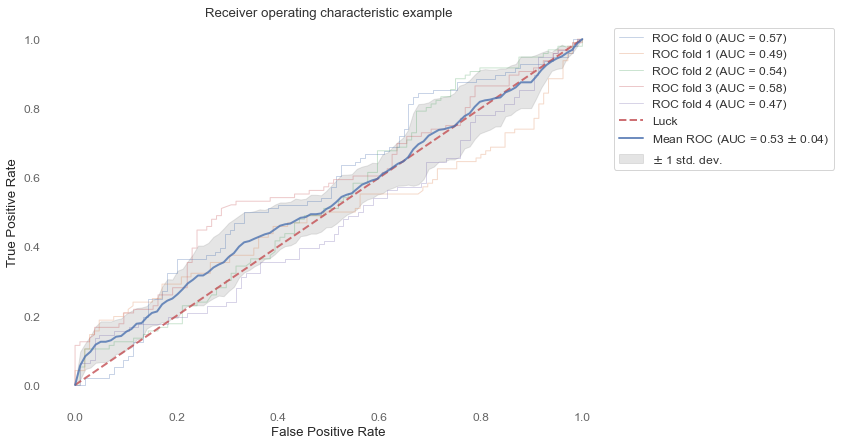

In [80]:
# Hyperparameters
n_estimator = 500     # Number of trees.
criterion = 'entropy' # It is a classifier, need to define metric of the model
                      # to optimize. Other option could be gini.
max_depth = 2         # Number of levels for each tree. When selecting a binary split
                      # we let the training to be slower.
n_jobs = 4            # Number of threads that will be opened to train faster.

skf = StratifiedKFold(n_splits=CV_SPLITS, shuffle=False)
rf_skf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                                criterion=criterion, n_jobs=n_jobs, random_state=123)
cv.crossValPlot(skf,rf_skf,X,y)

The model performs very poorly. We need to continue optimizing hyperparameters.

### 8.3. Cross-Validation with Embargo and Purge

Next, cross-validation considering Embargo and Purge is applied to reduce *leakage*.

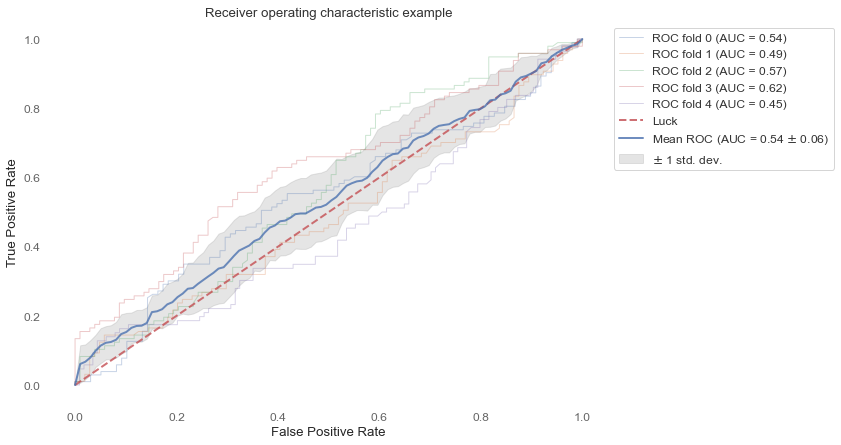

In [81]:
# Let's search for a better model trained with Cross-Validation (CV) + Embargo.
PCT_EMBARGO = 0.01 # In percentage

# Hyperparameters
n_estimator = 400     # Number of trees.
criterion = 'entropy' # It is a classifier, need to define metric of the model
                      # to optimize. Other option could be gini.
max_depth = 2         # Number of levels for each tree. When selecting a binary split
                      # we let the training to be slower.
n_jobs = 4            #  Number of threads that will be opened to train faster.
# To get more parameters, check https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

rf_pkf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                                criterion=criterion, n_jobs=n_jobs, random_state=123)

pkf = cv.PurgedKFold(n_splits=CV_SPLITS, t1=Xy.t1.copy(), pctEmbargo=PCT_EMBARGO)

cv.crossValPlot2(pkf,rf_pkf,Xy.copy()[['trgt', 'side', 'w']],Xy.copy().bin)

## 9. Betting Sizing

In [ ]:
# Take the predictions from a model and model the size of the bet based on the probability.
# Predict using the test set and compare the results.
NUM_CLASSES=2
JOBS=4

NUM_STEPS=5
STEP_SIZE=1/NUM_STEPS # No tocar!

# The probabilities and predictions need to be indexed series and paired with events (Xy).
x = Xy.copy()[['trgt', 'side']]
y_prob_df = pd.Series(data=rf.predict_proba(x.values)[:, 1], index=x.index)
y_pred_df = pd.Series(data=rf.predict(x.values), index=x.index)

bets = bet_sizing.getSignal(triple_barrier_events, STEP_SIZE, y_prob_df, y_pred_df, NUM_CLASSES, JOBS)
print('Bet size with respect to the total budget:')
print(bets)

/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/bet_sizing.py:74: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/bet_sizing.py:74: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/bet_sizing.py:74: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/bet_sizing.py:74: FutureWarning

Bet size with respect to the total budget:
2017-01-09    0.0
2017-01-11    0.2
2017-01-17    0.0
2017-01-19    0.0
2017-01-23    0.0
             ... 
2021-12-20    0.0
2021-12-21    0.0
2021-12-22    0.2
2021-12-23    0.2
2021-12-27    0.0
Length: 1074, dtype: float64


2022-04-05 17:52:08.695059 100.0% mpAvgActiveSignals done after 0.01 minutes. Remaining 0.0 minutes.
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/mpfin.py:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(out[0],pd.Series):df0=pd.Series()
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/mpfin.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in out:df0=df0.append(i)
/Users/agustin/Documents/agustin/workspace/mfin/financial_analytics/repo/trabajo_final/utils/mpfin.py:34: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  for i in out:df0=df0.append(i)
/Users/agustin/Documents/agustin/w

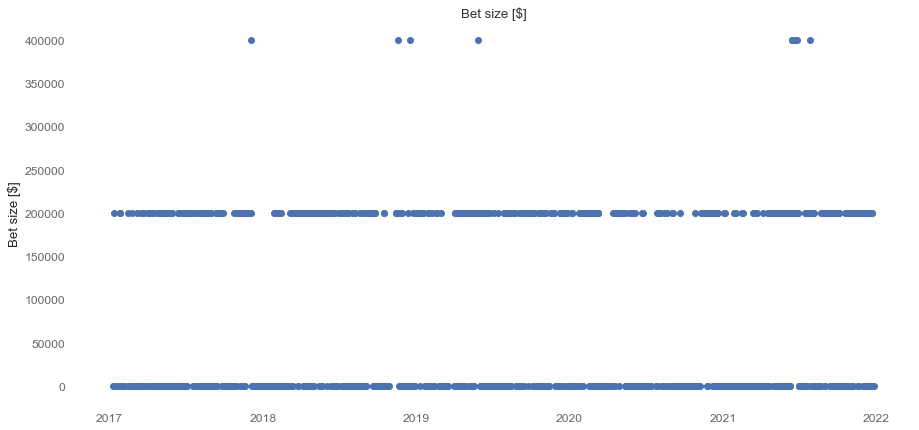

In [83]:
BUDGET=1000000

fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(x=bets.index, y=(bets * BUDGET))
plt.title('Bet size [$]')
plt.ylabel('Bet size [$]')
plt.grid()
plt.show()

## 10. Backtesting

In [84]:
# Baseline: buy and hold
base_returns = backtesting_and_metrics.daily_return(assets_data[TRADING_INSTRUMENT]['Close'])
value_df = backtesting_and_metrics.run_sample_and_hold_strategy(assets_data[TRADING_INSTRUMENT]['Close'], BUDGET)
backtesting_and_metrics.strategy_report(base_returns, "B&H")

-------------------------------------------------------------------
-------------------------------------------------------------------
Strategy: B&H
Sharpe: 2.221114627506448
Sortino: 2.900642678571171
Adjusted Sortino: 2.051064107816786
Win loss ratio: 1.1431282203852495
Win rate: 0.54733492442323
Avg loss: -0.04505351221556952
Avg win: 0.05150194124108908
Avg return: 0.007794659604781414
Volatility: 2.3770605965230645
Value at risk: -0.10248613100905658
-------------------------------------------------------------------
Sharpe: 0.11625845308519264
Annualized Sharpe: 2.221114627506448
STDDEV Sharpe: 0.028221563089934627
PSR: [0.999981014422841, 0.9999167758465278, 0.9996761516274154, 0.9988802127411833, 0.9965552034218274, 0.9905575515361814, 0.9768942485721132, 0.9494055865447533, 0.9005651239348489, 0.8239281761414543, 0.71772633107029, 0.5877501816681227, 0.4472637269455051, 0.3131587252317094, 0.20010238989741413, 0.11592741039310461, 0.06057873535723084, 0.028437350943314968, 0.

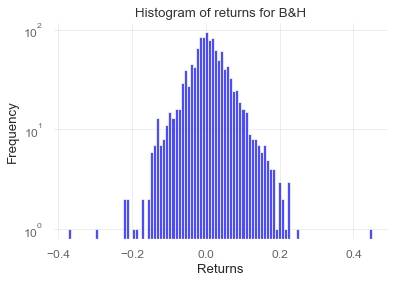

In [85]:
backtesting_and_metrics.plot_returns(base_returns, "B&H")

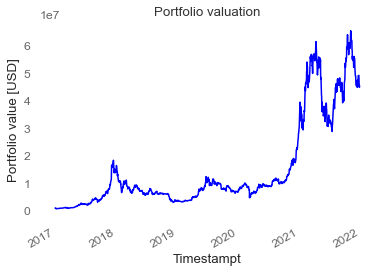

In [86]:
backtesting_and_metrics.plot_value(value_df)

In [87]:
params = {
    'budget': BUDGET,
    'buy_fee': 0.002,
    'sell_fee': 0.002,
    'short_fee':  np.power(1. + 0.01, num_days / 365.) - 1.,
    'pt': ptSl[0],
    'sl': ptSl[1],
    't1_length': num_days,
}
df, tx_costs = backtesting_and_metrics.build_portfolio_self_funded_df(assets_data[TRADING_INSTRUMENT]['Close'], bets, params)

In [88]:
# strategy_report(df['rets'].fillna(0.), 'SUT', underlying_asset_returns=base_returns)
backtesting_and_metrics.strategy_report(df['rets'], 'SUT', underlying_asset_returns=base_returns)

-------------------------------------------------------------------
-------------------------------------------------------------------
Strategy: SUT
Sharpe: 2.081021134368343
Sortino: 2.809195447554635
Adjusted Sortino: 1.9864011506442607
Win loss ratio: 1.4151464899899355
Win rate: 0.503
Avg loss: -0.005119124602857803
Avg win: 0.0072443112135553425
Avg return: 0.0010996836127980093
Volatility: 0.2845278811304615
Value at risk: -0.012316372716770545
Correlation to underlying:            rets     Close
rets   1.000000  0.848608
Close  0.848608  1.000000
-------------------------------------------------------------------
Sharpe: 0.10901320616068541
Annualized Sharpe: 2.0826943793707984
STDDEV Sharpe: 0.027900551526701473
PSR: [0.9999533152536586, 0.9998064974147008, 0.9992895571355769, 0.9976868079112428, 0.9933109596009406, 0.9827904320776156, 0.9605164603687174, 0.9189877746469034, 0.8508020110720402, 0.7522108574985922, 0.6266704026286942, 0.4858930485924445, 0.34687021861625517, 0.

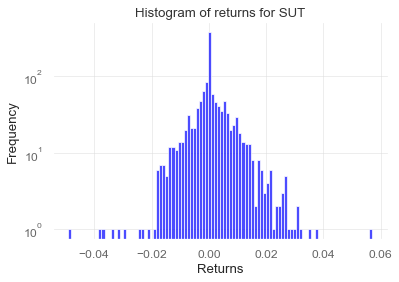

In [89]:
backtesting_and_metrics.plot_returns(df['rets'], "SUT")

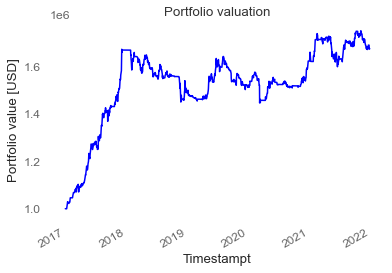

In [90]:
backtesting_and_metrics.plot_value(df['Value'])

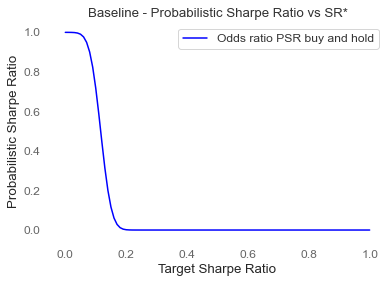

In [91]:
sr_stars = np.asarray([i / 100. for i in range(0, 101)])
psrs = [sharpe_ratio_stats.probabilistic_sharpe_ratio(returns=base_returns, sr_benchmark=sr_star) for sr_star in sr_stars]

plt.plot(sr_stars, psrs, color='blue', label='Odds ratio PSR buy and hold')
plt.legend()
plt.xlabel('Target Sharpe Ratio')
plt.ylabel('Probabilistic Sharpe Ratio')
plt.title('Baseline - Probabilistic Sharpe Ratio vs SR*')
plt.grid()
plt.show()

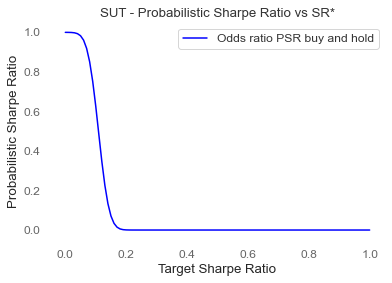

In [92]:
sr_stars = np.asarray([i / 100. for i in range(0, 101)])
psrs = [sharpe_ratio_stats.probabilistic_sharpe_ratio(returns=df['rets'], sr_benchmark=sr_star) for sr_star in sr_stars]


plt.plot(sr_stars, psrs, color='blue', label='Odds ratio PSR buy and hold')
plt.legend()
plt.xlabel('Target Sharpe Ratio')
plt.ylabel('Probabilistic Sharpe Ratio')
plt.title('SUT - Probabilistic Sharpe Ratio vs SR*')
plt.grid()
plt.show()